Imports

In [1]:
import numpy as np
import pandas as pd
import pickle
from sentence_transformers import SentenceTransformer
import time
import math
import re
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the SBERT model
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

In [3]:
def create_tf_matrix(sentences):
    tf_matrix = []
    for list in sentences:
        tf_table = []
        # Determining frequency of words in the sentence
        word_freq = {}
        for word in list:
            word_freq[word] = (word_freq[word] + 1) if word in  word_freq else 1
        # Calculating tf of the words in the sentence
        for word in list:
            tf_table.append((word, math.log10(word_freq[word] + 1)))
        tf_matrix.append(tf_table)
    return tf_matrix

In [4]:
def create_idf_matrix(sentences):

    idf_matrix = []

    documents_count = len(sentences)
    total_words_corpus = []

    # Getting words in the sentence
    for list in sentences:
        total_words_corpus.append(list)

    # Determining word count table with the count of sentences which contains the word.
    word_in_docs = {}
    for list in sentences:
        for word in list:
            word_in_docs[word] = (word_in_docs[word] + 1) if word in word_in_docs else 1

    # Determining idf of the words in the sentence.
    for list in sentences:
        idf_table = []
        for word in list:
            idf_table.append((word, math.log10(documents_count / float(word_in_docs[word]))))

        idf_matrix.append(idf_table)

    return idf_matrix

In [5]:
def create_tf_idf_matrix(tf_matrix, idf_matrix):

    tf_idf_matrix = []

    for i in range(len(tf_matrix)):
        tf_idf_table = []
        tf_of_sentence_words = tf_matrix[i]
        idf_of_sentence_words = idf_matrix[i]

        for word in range(len(tf_of_sentence_words)):
            word_tf, tf_value = tf_of_sentence_words[word]
            word_idf, idf_value = idf_of_sentence_words[word]
            tf_idf_table.append((word_tf, tf_value * idf_value))

        tf_idf_matrix.append(tf_idf_table)

    return tf_idf_matrix

In [6]:
def calculate_sentence_scores(tf_idf_matrix, df_train):
    df_train["tf_idf_score"] = 0
    for sentence in range(len(tf_idf_matrix)):
        sum_of_tf_idf = 0
        len_of_sentence = len(tf_idf_matrix[sentence])
        for i in range(len_of_sentence):
            word, value = tf_idf_matrix[sentence][i]
            sum_of_tf_idf += value
        df_train["tf_idf_score"][sentence] = sum_of_tf_idf/len_of_sentence

    return df_train

In [7]:
def cosine_similarity(vector1, vector2):
    dot_product = np.dot(vector1, vector2)
    norm_vector1 = np.linalg.norm(vector1)
    norm_vector2 = np.linalg.norm(vector2)
    similarity = dot_product / (norm_vector1 * norm_vector2)
    return similarity

In [8]:
def dimensionality_reduction_with_clustering(X_data, y_data, tf_idf_matrix):
    similarity_threshold = 0.65

    embeddings = []
    y_train_reduced = []

    for i in range(len(X_data)):
        flag = 0
        for j in range(i+1, len(X_data)):
            sim = cosine_similarity(X_data[i], X_data[j])
            if sim >= similarity_threshold:
                if tf_idf_matrix[i] >= tf_idf_matrix[j] and flag == 0:
                    embeddings.append(X_data[i])
                    y_train_reduced.append(y_data[i])
                    flag = 1
                elif tf_idf_matrix[i] < tf_idf_matrix[j] and flag == 0:
                    embeddings.append(X_data[j])
                    y_train_reduced.append(y_data[j])
    return embeddings, y_train_reduced




In [9]:
baseline_results = {}
def svm_classification(baseline_results, X_train, y_train, X_dev, y_dev, kernel="rbf"):
      
    beg = time.time()  
    clf = SVC(kernel=kernel)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_dev)

    end = time.time()
    baseline_results[f'SVM-{kernel}'] = classification_report(y_dev, y_pred, output_dict=True)
    baseline_results[f'SVM-{kernel}']['infer_time'] = end-beg

    print(f"SVM with kernel: {kernel}", end='\t')
    print(clf.score(X_dev, y_dev))

In [10]:
def mlp_classification(baseline_results, X_train, y_train, X_dev, y_dev, layers=[200, 100]):
    for layer in layers:
        beg = time.time()
        clf = MLPClassifier(hidden_layer_sizes=layer, max_iter=3000)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_dev)
        end = time.time()
        baseline_results[f'MLP-{layer}'] = classification_report(y_dev, y_pred, output_dict=True)
        baseline_results[f'MLP-{layer}']['infer_time'] = end-beg
        
        print(f"MLP with layers: {layer}", end='\t')
        print(clf.score(X_dev, y_dev))

In [11]:
def random_forest_classification(baseline_results, X_train, y_train, X_dev, y_dev, n_estimators=100):
        
    beg = time.time()
    clf = RandomForestClassifier(n_estimators=n_estimators)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_dev)
    end = time.time()
    baseline_results[f'RandomForest-{n_estimators}'] = classification_report(y_dev, y_pred, output_dict=True)
    baseline_results[f'RandomForest-{n_estimators}']['infer_time'] = end-beg
        
    print(f"Random Forest with n_estimators: {n_estimators}", end='\t')
    print(clf.score(X_dev, y_dev))

In [12]:
def knn_classification(baseline_results, X_train, y_train, X_dev, y_dev, n_neighbors=50):

    beg = time.time()
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_dev)
    end = time.time()
    baseline_results[f'KNN-{n_neighbors}'] = classification_report(y_dev, y_pred, output_dict=True)
    baseline_results[f'KNN-{n_neighbors}']['infer_time'] = end-beg

    print(f"KNN with n_neighbors: {n_neighbors}", end='\t')
    print(clf.score(X_dev, y_dev))

In [13]:
# plot the best results for each classifier


def plot_results(baseline_results, metric, threshold=-1, figsize=(10, 5), title='Baseline Results'):
    plt.rcParams['figure.dpi'] = 300
    sorted_results = sorted([(k, v['macro avg'][metric]) for k, v in baseline_results.items()], key=lambda x: x[1], reverse=True)
    plt.figure(figsize=figsize)
    plt.title(title)
    plt.xlabel(metric)
    plt.ylabel("Classifier")
    sns.barplot(x=[x[1] for x in sorted_results if x[1] > threshold], y=[x[0] for x in sorted_results if x[1] > threshold]) 
    plt.xlim(0, min(max([x[1] for x in sorted_results])+0.07, 1))
    
    # put the scores on the bars
    for i, v in enumerate([x[1] for x in sorted_results]):
        if v > threshold:
            # set fonr size
            plt.text(v, i + .26, f'{v:.3f}', color='black', rotation=-90, fontsize=8)

def plot_sizes(sizes, title, xlabel, figsize=(10, 5), is_ratio=False):
    # set dpi
    plt.rcParams['figure.dpi'] = 300
    sorted_sizes = sorted([(k, v) for k, v in sizes.items()], key=lambda x: x[1], reverse=True)
    plt.figure(figsize=figsize)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Method")

    if is_ratio:
        sns.barplot(x=[x[1] for x in sorted_sizes], y=[x[0] for x in sorted_sizes])
        plt.xlim(0, max([x[1] for x in sorted_sizes])+10)
        # for i, v in enumerate([x[1] for x in sorted_sizes]):
        #     plt.text(v, i + .25, f'{v:.2f}', color='black')
    else:
        sns.barplot(x=[x[1]/(1024*1024) for x in sorted_sizes], y=[x[0] for x in sorted_sizes])
        plt.xlim(0, 10)
        for i, v in enumerate([x[1] for x in sorted_sizes]):
            plt.text(v/(1024*1024), i + .25, f'{v/(1024*1024):.2f} MB', color='black')


    plt.tight_layout()

def plot_inference_time(inference_times, title, xlabel, figsize=(10, 5)):
    plt.rcParams['figure.dpi'] = 300
    sorted_inference_times = sorted([(k, v['infer_time']) for k, v in inference_times.items()], key=lambda x: x[1], reverse=True)
    plt.figure(figsize=figsize)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Classifier")
    # vertical barplot

    sns.barplot(x=[x[1] for x in sorted_inference_times], y=[x[0] for x in sorted_inference_times])

    
    plt.xlim(0, 6)
    for i, v in enumerate([x[1] for x in sorted_inference_times]):
        plt.text(v, i + .25, f'{v:.2f} s', color='black')

    plt.tight_layout()


***Check That Lab Dataset***

Load Data

In [14]:
df = pd.read_table('datasets/CheckThat_Lab/train_ml.tsv')
df = df.sample(n=df.shape[0], random_state=2000, replace=False).reset_index(drop=True)
df_train, df_dev = np.split(df, [int(.9*len(df))])

df_test = pd.read_table('datasets/CheckThat_Lab/test_ml.tsv')
df_test = df_test.sample(n=df_test.shape[0], random_state=2000, replace=False).reset_index(drop=True)

Generate SBERT embeddings

In [15]:
# X_train = model.encode(list(df_train.sentence))
# X_dev = model.encode(list(df_dev.sentence))
# X_test = model.encode(list(df_test.sentence))

# y_train = df_train["label"]
# y_dev = df_dev["label"]

In [16]:
# # save the embedding results
# pickle.dump(X_train, open("datasets/CheckThat_Lab/embeddings/train_embeddings_originals.p","wb" ))
# pickle.dump(X_dev, open("datasets/CheckThat_Lab/embeddings/dev_embeddings_originals.p", "wb"))
# pickle.dump(X_test, open("datasets/CheckThat_Lab/embeddings/test_embeddings_originals.p", "wb"))

# # save the labels
# pickle.dump(y_train, open("datasets/CheckThat_Lab/embeddings/train_labels_originals.p", "wb"))
# pickle.dump(y_dev, open("datasets/CheckThat_Lab/embeddings/dev_labels_originals.p", "wb"))

In [17]:
# load the embeddings
X_train = pickle.load(open("datasets/CheckThat_Lab/embeddings/train_embeddings_originals.p", "rb"))
X_dev = pickle.load(open("datasets/CheckThat_Lab/embeddings/dev_embeddings_originals.p", "rb"))
X_test = pickle.load(open("datasets/CheckThat_Lab/embeddings/test_embeddings_originals.p", "rb"))

# load the labels
y_train = pickle.load(open("datasets/CheckThat_Lab/embeddings/train_labels_originals.p", "rb"))
y_dev = pickle.load(open("datasets/CheckThat_Lab/embeddings/dev_labels_originals.p", "rb"))

Calculate TF-IDF Score

In [18]:
#Tokenize each senetence
df_train["list_of_words"] = 0

for i in range(len(df_train['sentence'])):
    sentence = df["sentence"][i].lower()
    sentence = re.sub(r'[^\w\s]', '', sentence)
 
    result = sentence.split()
    df_train["list_of_words"][i] = result
    

C:\Users\HP\AppData\Local\Temp\ipykernel_7560\3761323428.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["list_of_words"][i] = result


In [19]:
tf_matrix = create_tf_matrix(df_train["list_of_words"])
idf_matrix = create_idf_matrix(df_train["list_of_words"])

tf_idf_matrix = create_tf_idf_matrix(tf_matrix, idf_matrix)

In [20]:
df_train = calculate_sentence_scores(tf_idf_matrix, df_train)

C:\Users\HP\AppData\Local\Temp\ipykernel_7560\1346757543.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["tf_idf_score"][sentence] = sum_of_tf_idf/len_of_sentence


Cluster Embeddings on Similarity and Dimensionality Reduction

In [21]:
embeddings, y_train_reduced = dimensionality_reduction_with_clustering(X_train, y_train, tf_idf_matrix)

X_train_reduced = np.array(embeddings)
y_train_reduced = np.array(y_train_reduced)

Classification

SVM

In [22]:
svm_classification(baseline_results, X_train_reduced, y_train_reduced, X_dev, y_dev)

SVM with kernel: rbf	0.7435897435897436


MLP

In [23]:
mlp_classification(baseline_results, X_train_reduced, y_train_reduced, X_dev, y_dev)

MLP with layers: 200	0.7134238310708899
MLP with layers: 100	0.7104072398190046


Random Forest

In [25]:
random_forest_classification(baseline_results, X_train_reduced, y_train_reduced, X_dev, y_dev)

Random Forest with n_estimators: 100	0.7300150829562594


KNN

In [26]:
knn_classification(baseline_results, X_train_reduced, y_train_reduced, X_dev, y_dev)

KNN with n_neighbors: 50	0.6877828054298643


Plot Results

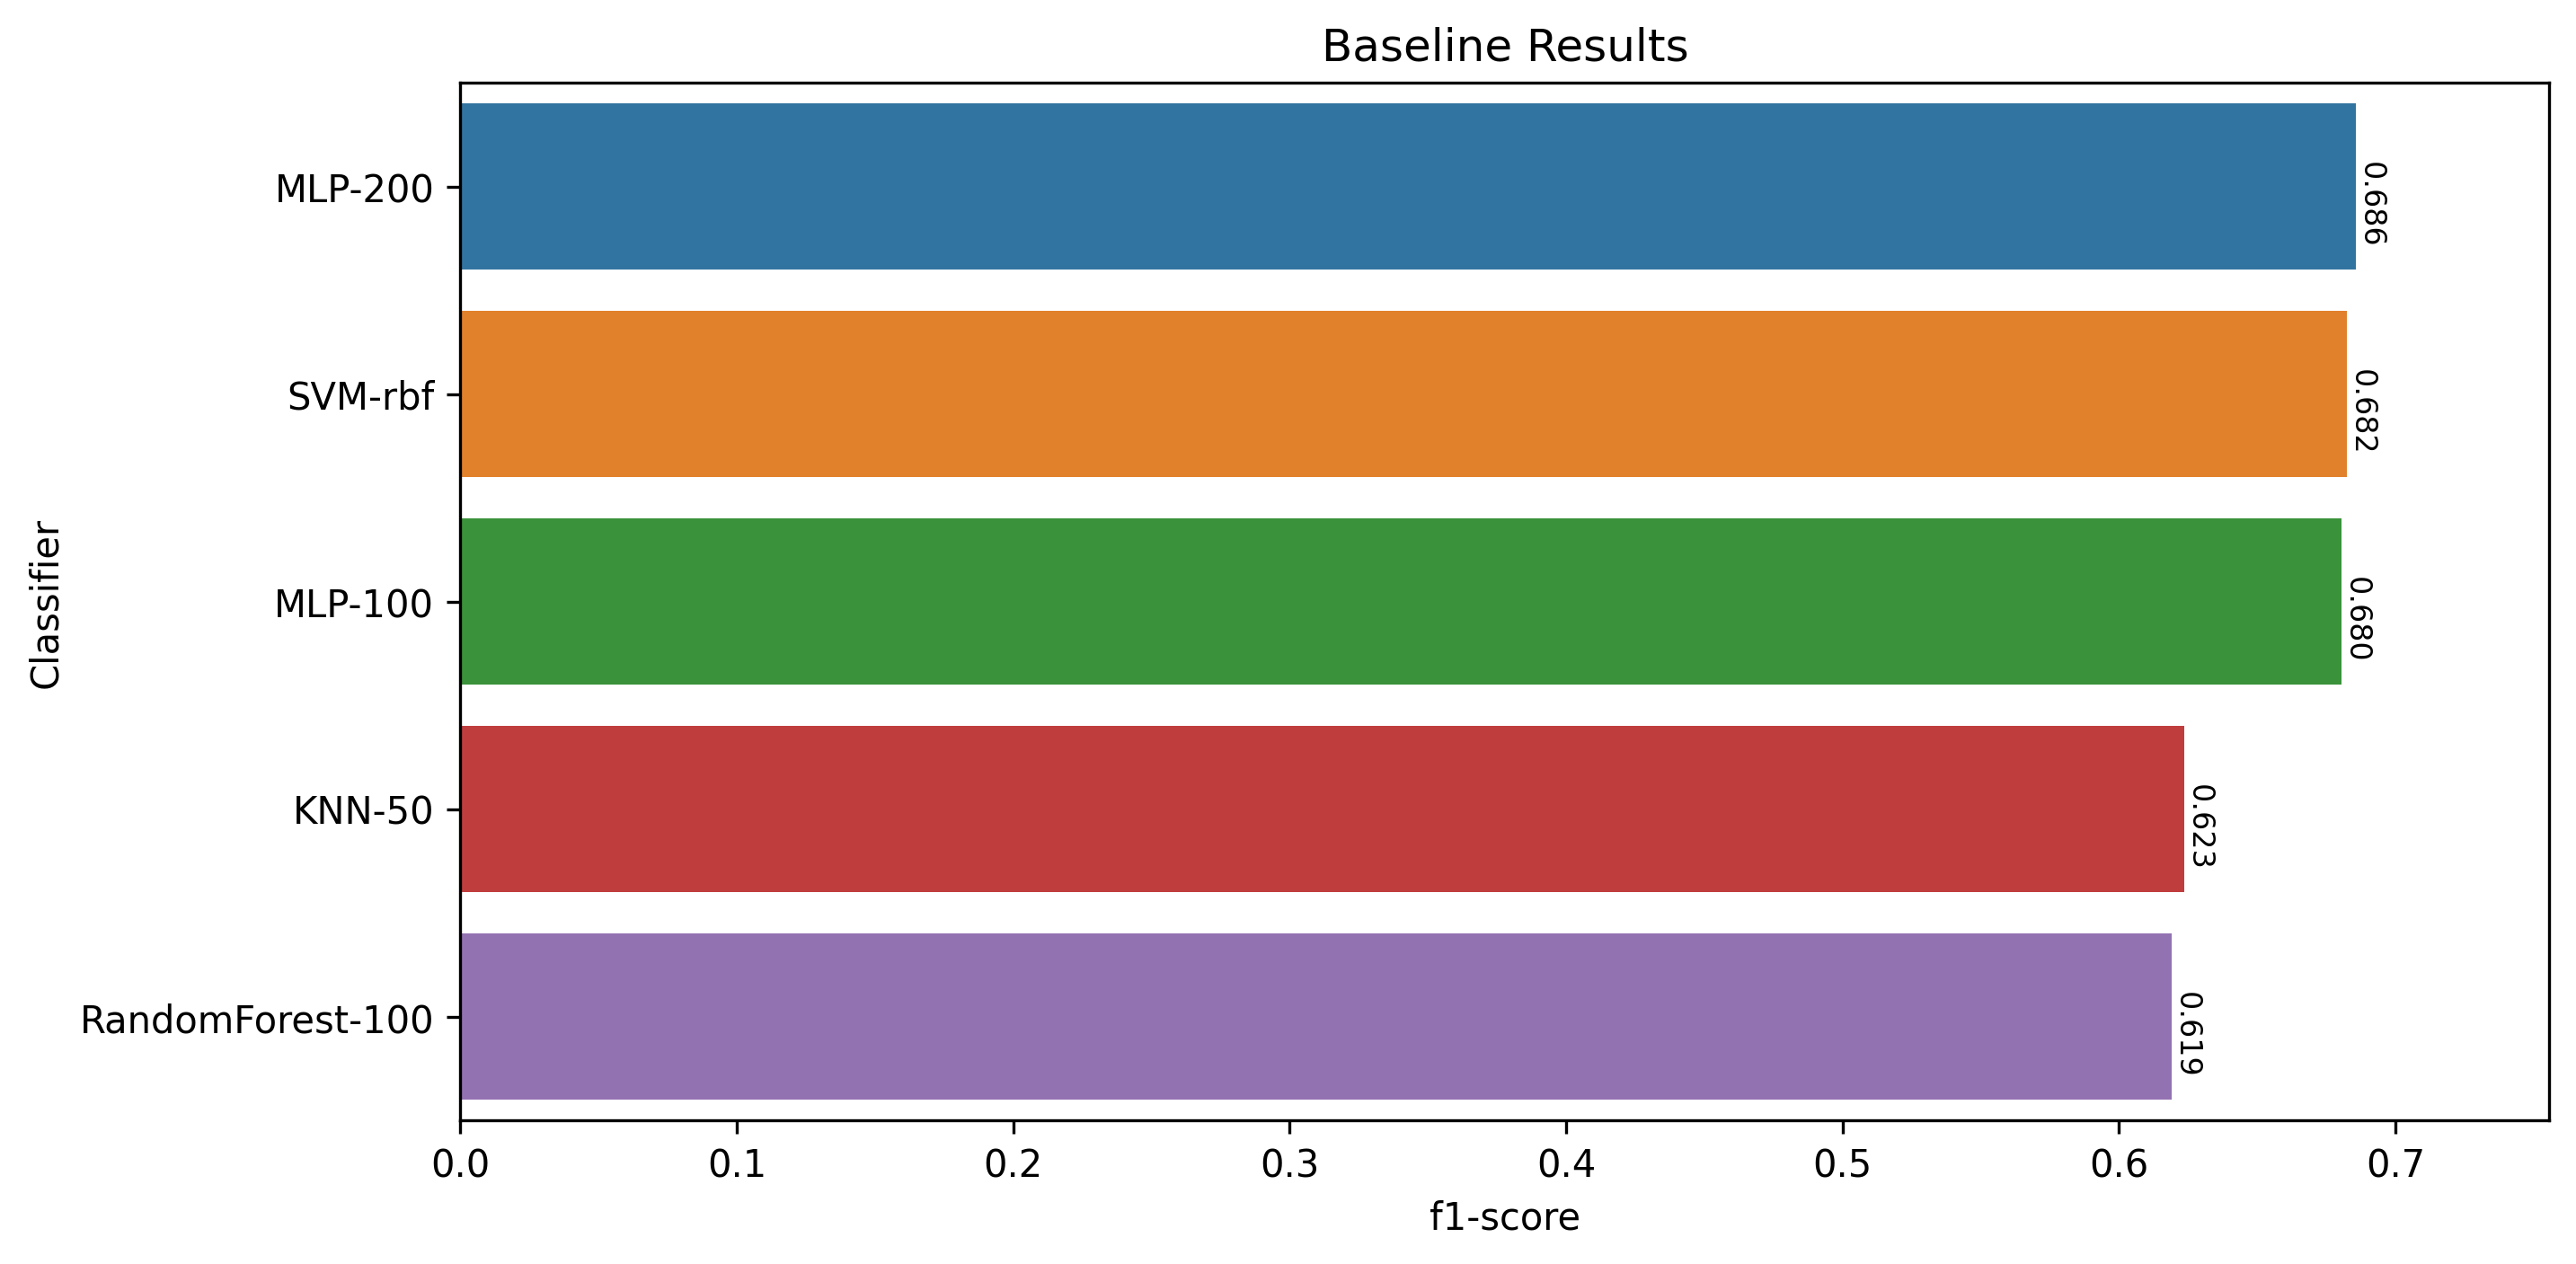

In [27]:
plot_results(baseline_results, 'f1-score')

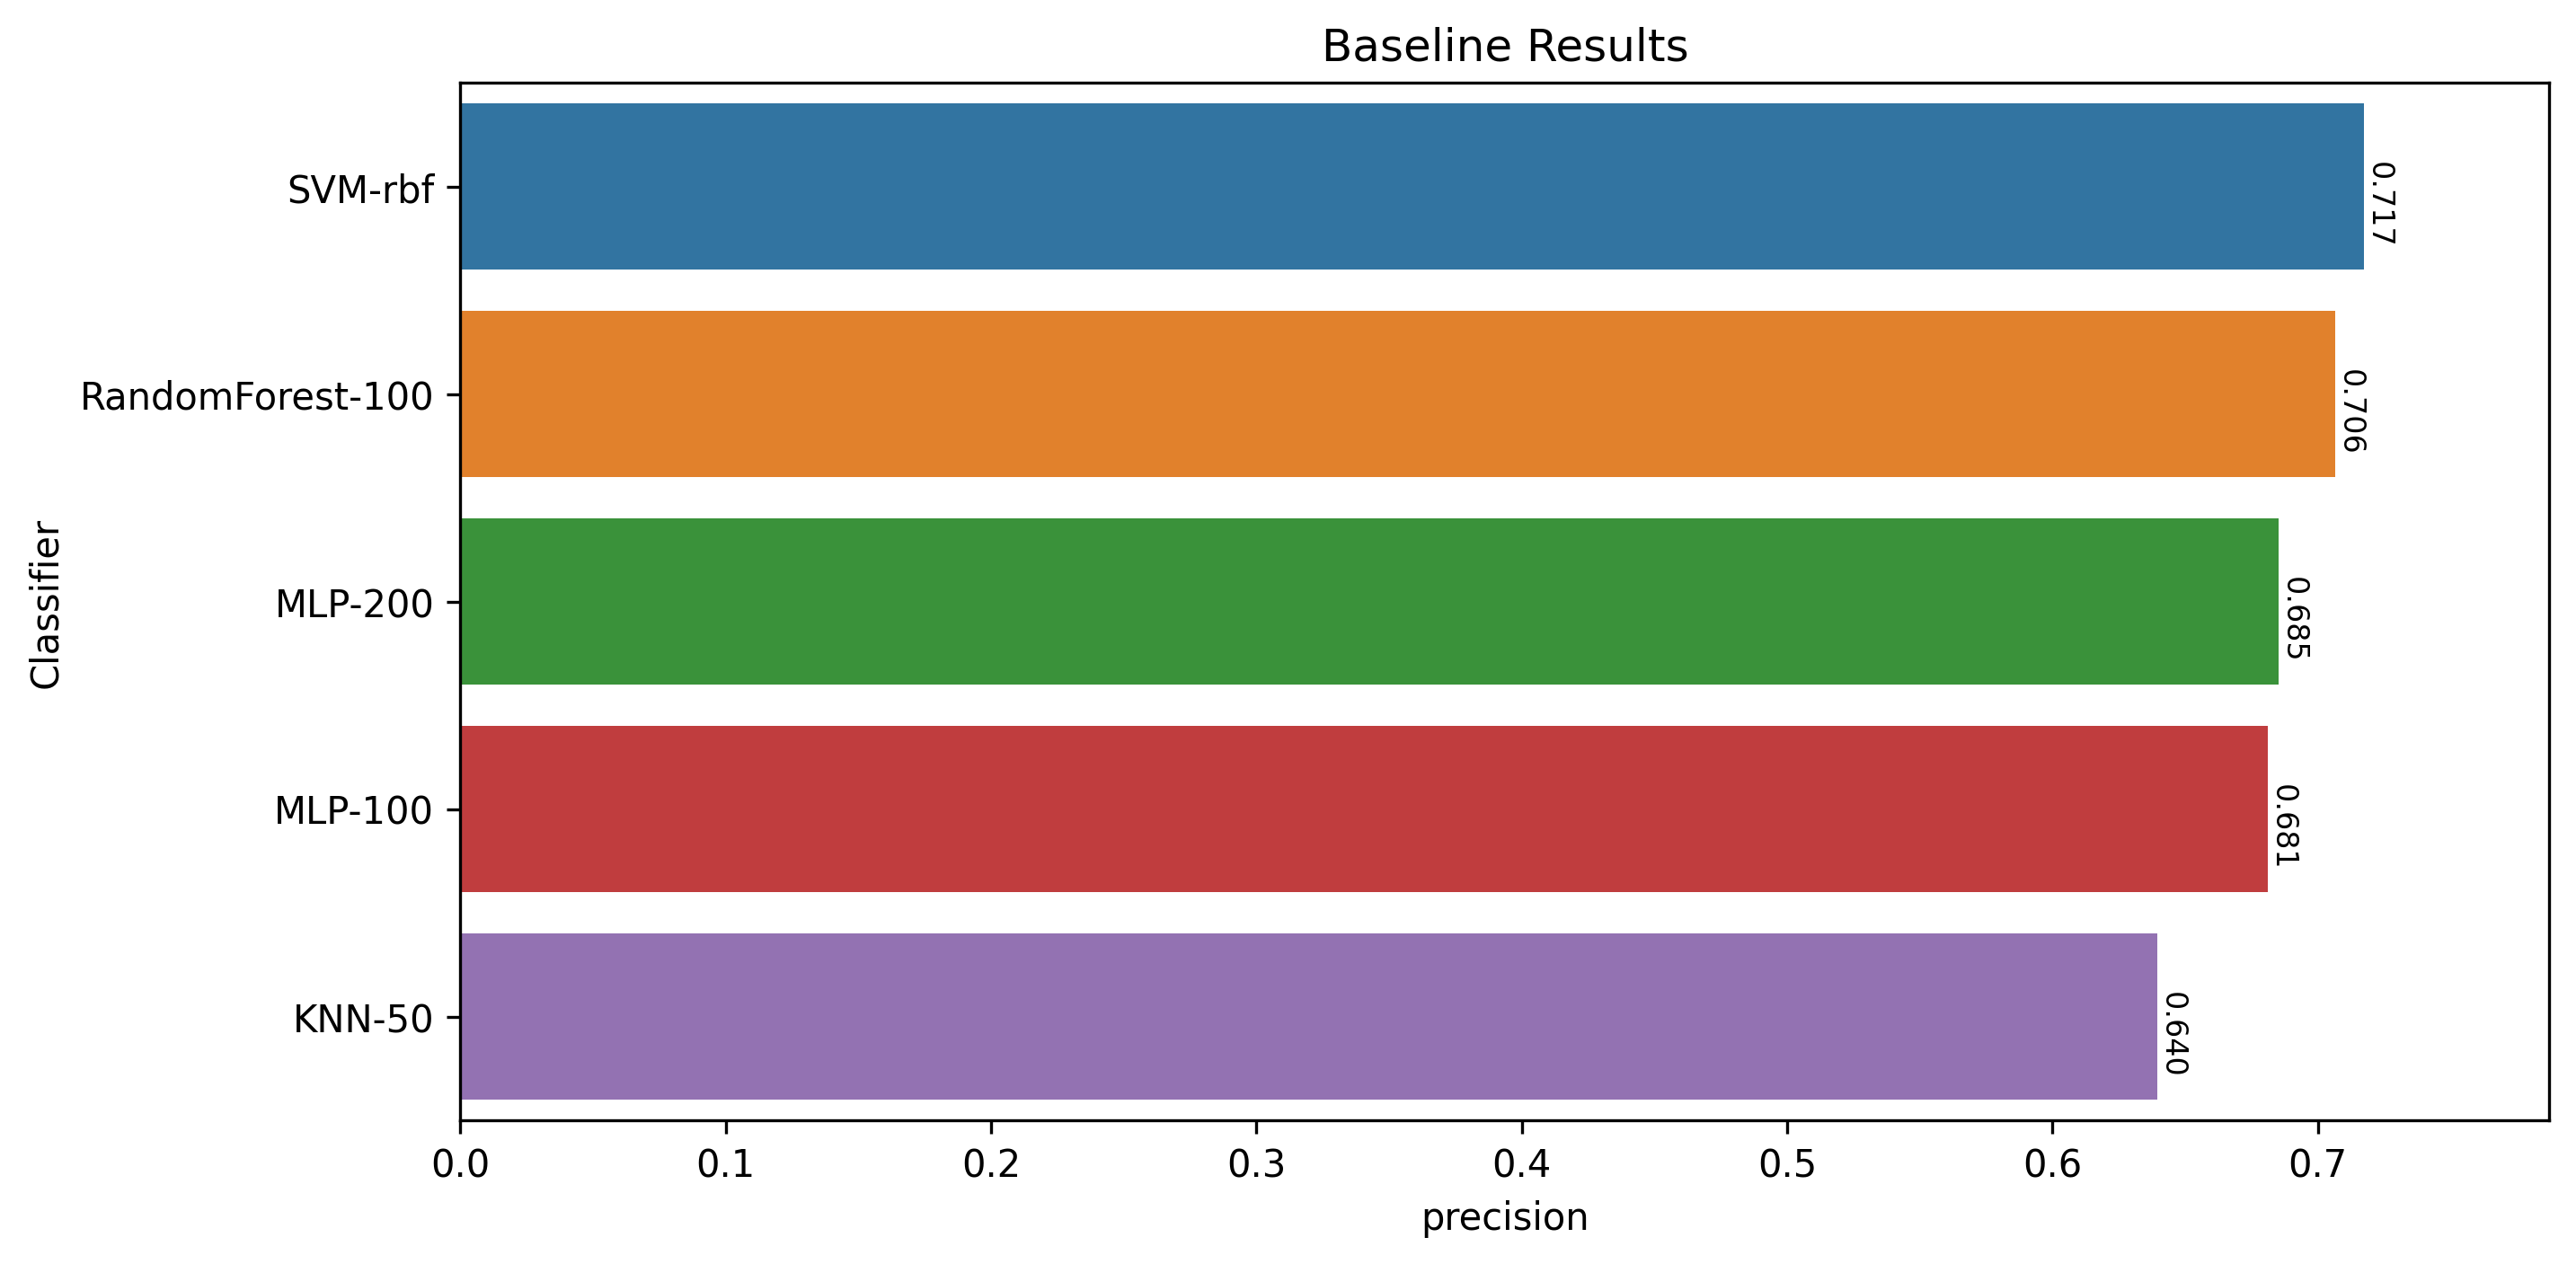

In [100]:
plot_results(baseline_results, 'precision')

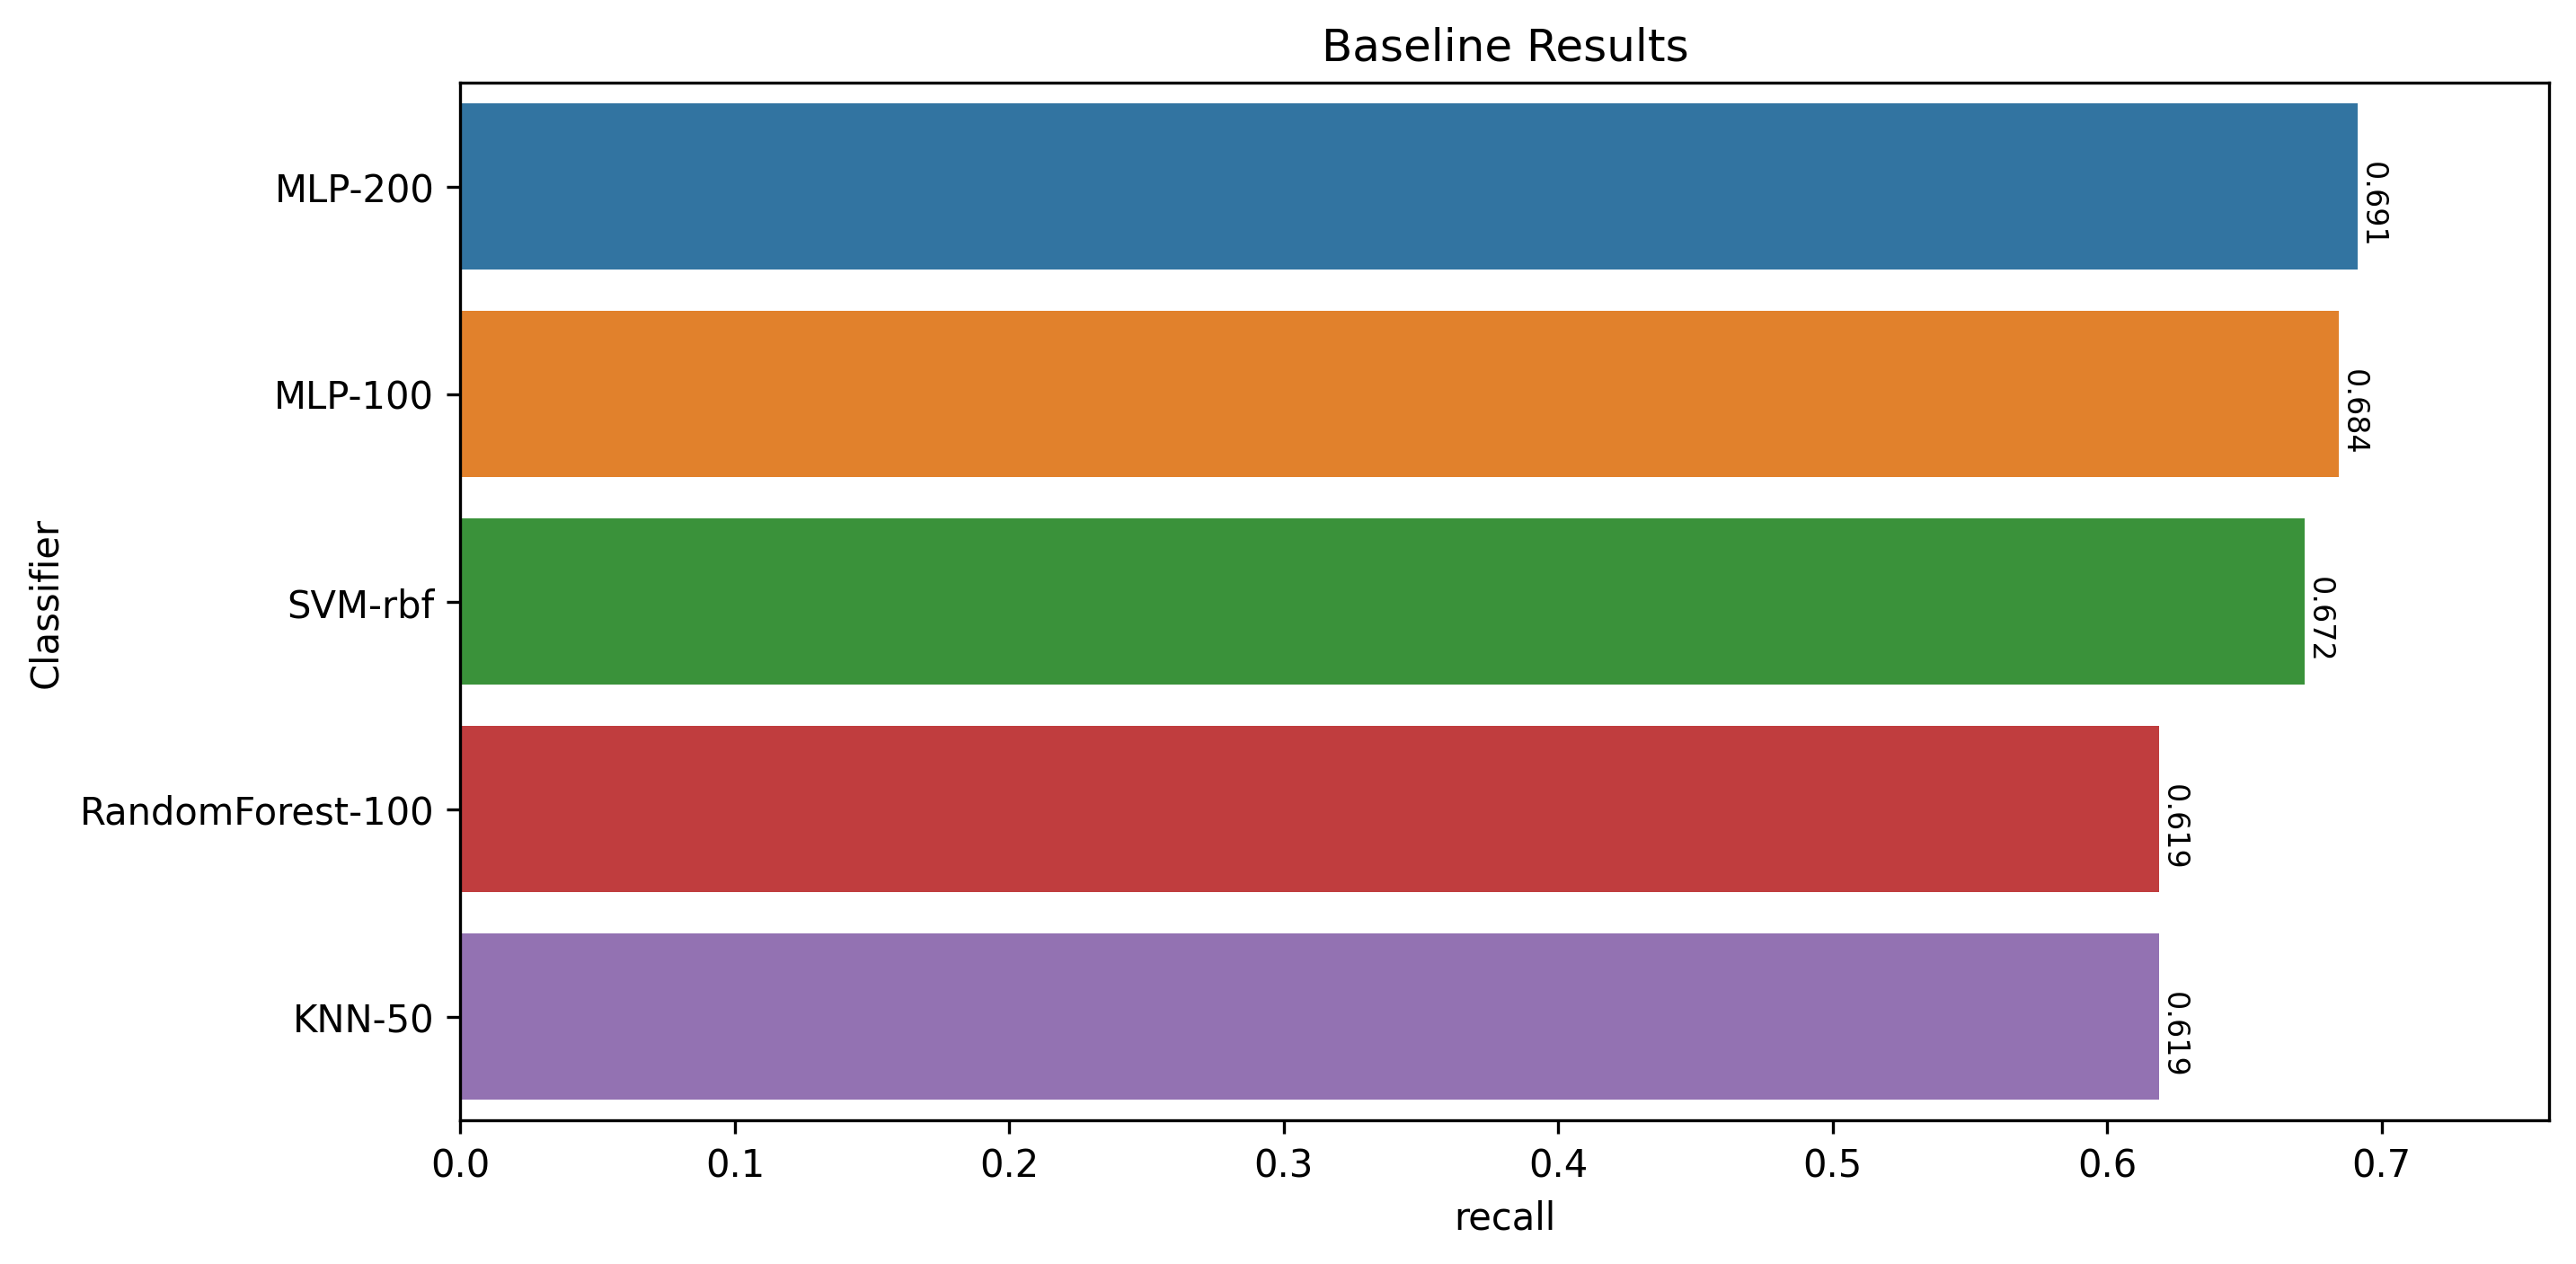

In [28]:
plot_results(baseline_results, 'recall')

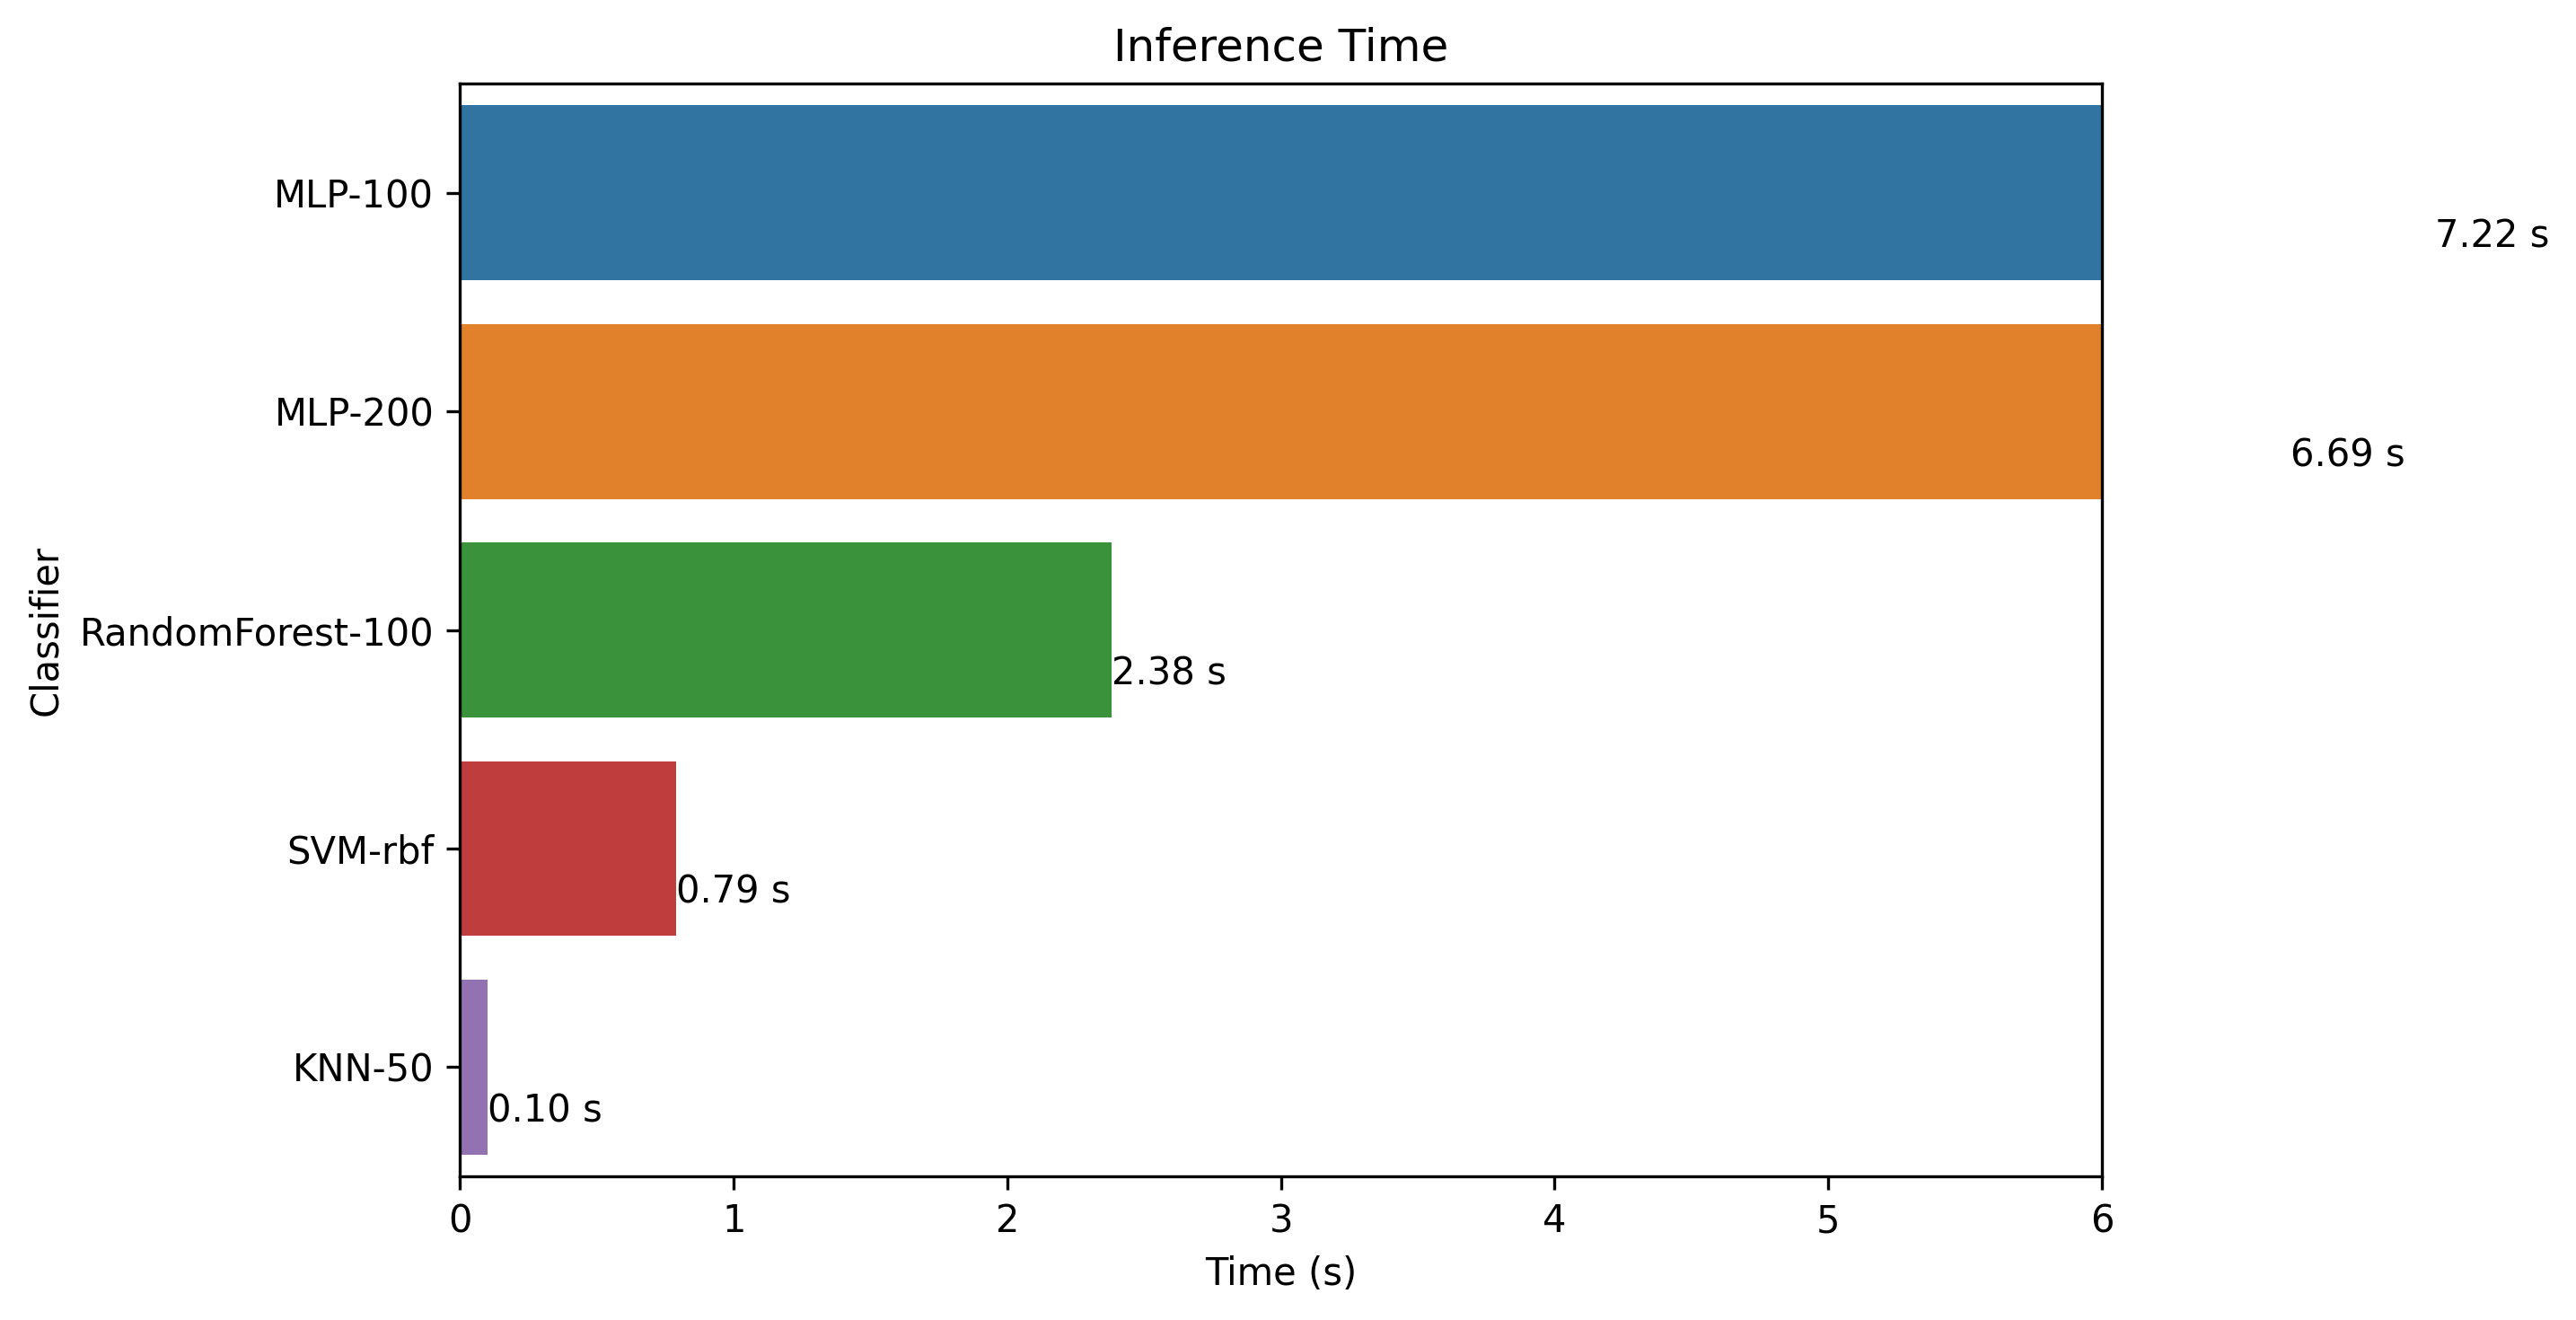

In [102]:
plot_inference_time(baseline_results, 'Inference Time', 'Time (s)')

In [29]:
baseline_results["size"] = X_train_reduced.nbytes

In [31]:
with open("results_chechThatLab.pickle", "wb") as pickle_file:
    pickle.dump(baseline_results, pickle_file)

***FEVER DATASET***

In [32]:
df = pd.read_csv('datasets/FEVER/Train.csv')
df.rename(columns={'claim': 'sentence'}, inplace=True)
df = df.sample(n=df.shape[0], random_state=2000, replace=False).reset_index(drop=True)
df_train, df_dev = np.split(df, [int(.9*len(df))])

df_test = pd.read_csv('datasets/FEVER/Test.csv')
df_test.rename(columns={'claim': 'sentence'}, inplace=True)
df_test = df_test.sample(n=df_test.shape[0], random_state=2000, replace=False).reset_index(drop=True)

Generate SBERT embeddings

In [33]:
# X_train = model.encode(list(df_train.sentence))
# X_dev = model.encode(list(df_dev.sentence))
# X_test = model.encode(list(df_test.sentence))

# y_train = df_train["label"]
# y_dev = df_dev["label"]

In [34]:
# # save the embedding results
# pickle.dump(X_train, open("datasets/FEVER/embeddings/SBERT/train_embeddings_originals.p","wb" ))
# pickle.dump(X_dev, open("datasets/FEVER/embeddings/SBERT/dev_embeddings_originals.p", "wb"))
# pickle.dump(X_test, open("datasets/FEVER/embeddings/SBERT/test_embeddings_originals.p", "wb"))

# # save the labels
# pickle.dump(y_train, open("datasets/FEVER/embeddings/SBERT/train_labels_originals.p", "wb"))
# pickle.dump(y_dev, open("datasets/FEVER/embeddings/SBERT/dev_labels_originals.p", "wb"))

In [35]:
# load the embeddings
X_train = pickle.load(open("datasets/FEVER/embeddings/SBERT/train_embeddings_originals.p", "rb"))
X_dev = pickle.load(open("datasets/FEVER/embeddings/SBERT/dev_embeddings_originals.p", "rb"))
X_test = pickle.load(open("datasets/FEVER/embeddings/SBERT/test_embeddings_originals.p", "rb"))

# load the labels
y_train = pickle.load(open("datasets/FEVER/embeddings/SBERT/train_labels_originals.p", "rb"))
y_dev = pickle.load(open("datasets/FEVER/embeddings/SBERT/dev_labels_originals.p", "rb"))

Calculate TF-IDF Score

In [36]:

#Tokenize each senetence
df_train["list_of_words"] = 0

for i in range(len(df_train['sentence'])):
    sentence = df["sentence"][i].lower()
    sentence = re.sub(r'[^\w\s]', '', sentence)
 
    result = sentence.split()
    df_train["list_of_words"][i] = result
    


C:\Users\HP\AppData\Local\Temp\ipykernel_7560\493725891.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["list_of_words"][i] = result


In [37]:

tf_matrix = create_tf_matrix(df_train["list_of_words"])
idf_matrix = create_idf_matrix(df_train["list_of_words"])

tf_idf_matrix = create_tf_idf_matrix(tf_matrix, idf_matrix)
df_train = calculate_sentence_scores(tf_idf_matrix, df_train)


C:\Users\HP\AppData\Local\Temp\ipykernel_7560\1346757543.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["tf_idf_score"][sentence] = sum_of_tf_idf/len_of_sentence


Cluster Embeddings on Similarity and Dimensionality Reduction


In [38]:
embeddings, y_train_reduced = dimensionality_reduction_with_clustering(X_train, y_train, tf_idf_matrix)

X_train_reduced = np.array(embeddings)
y_train_reduced = np.array(y_train_reduced)

Classification

In [50]:
baseline_results = {}

SVM

In [51]:
svm_classification(baseline_results, X_train_reduced, y_train_reduced, X_dev, y_dev)

SVM with kernel: rbf	0.496


MLP

In [52]:
mlp_classification(baseline_results, X_train_reduced, y_train_reduced, X_dev, y_dev)

MLP with layers: 200	0.502
MLP with layers: 100	0.506


Random Forest

In [53]:
random_forest_classification(baseline_results, X_train_reduced, y_train_reduced, X_dev, y_dev)

Random Forest with n_estimators: 100	0.484


KNN

In [54]:
knn_classification(baseline_results, X_train_reduced, y_train_reduced, X_dev, y_dev)

KNN with n_neighbors: 50	0.476


Plot Results

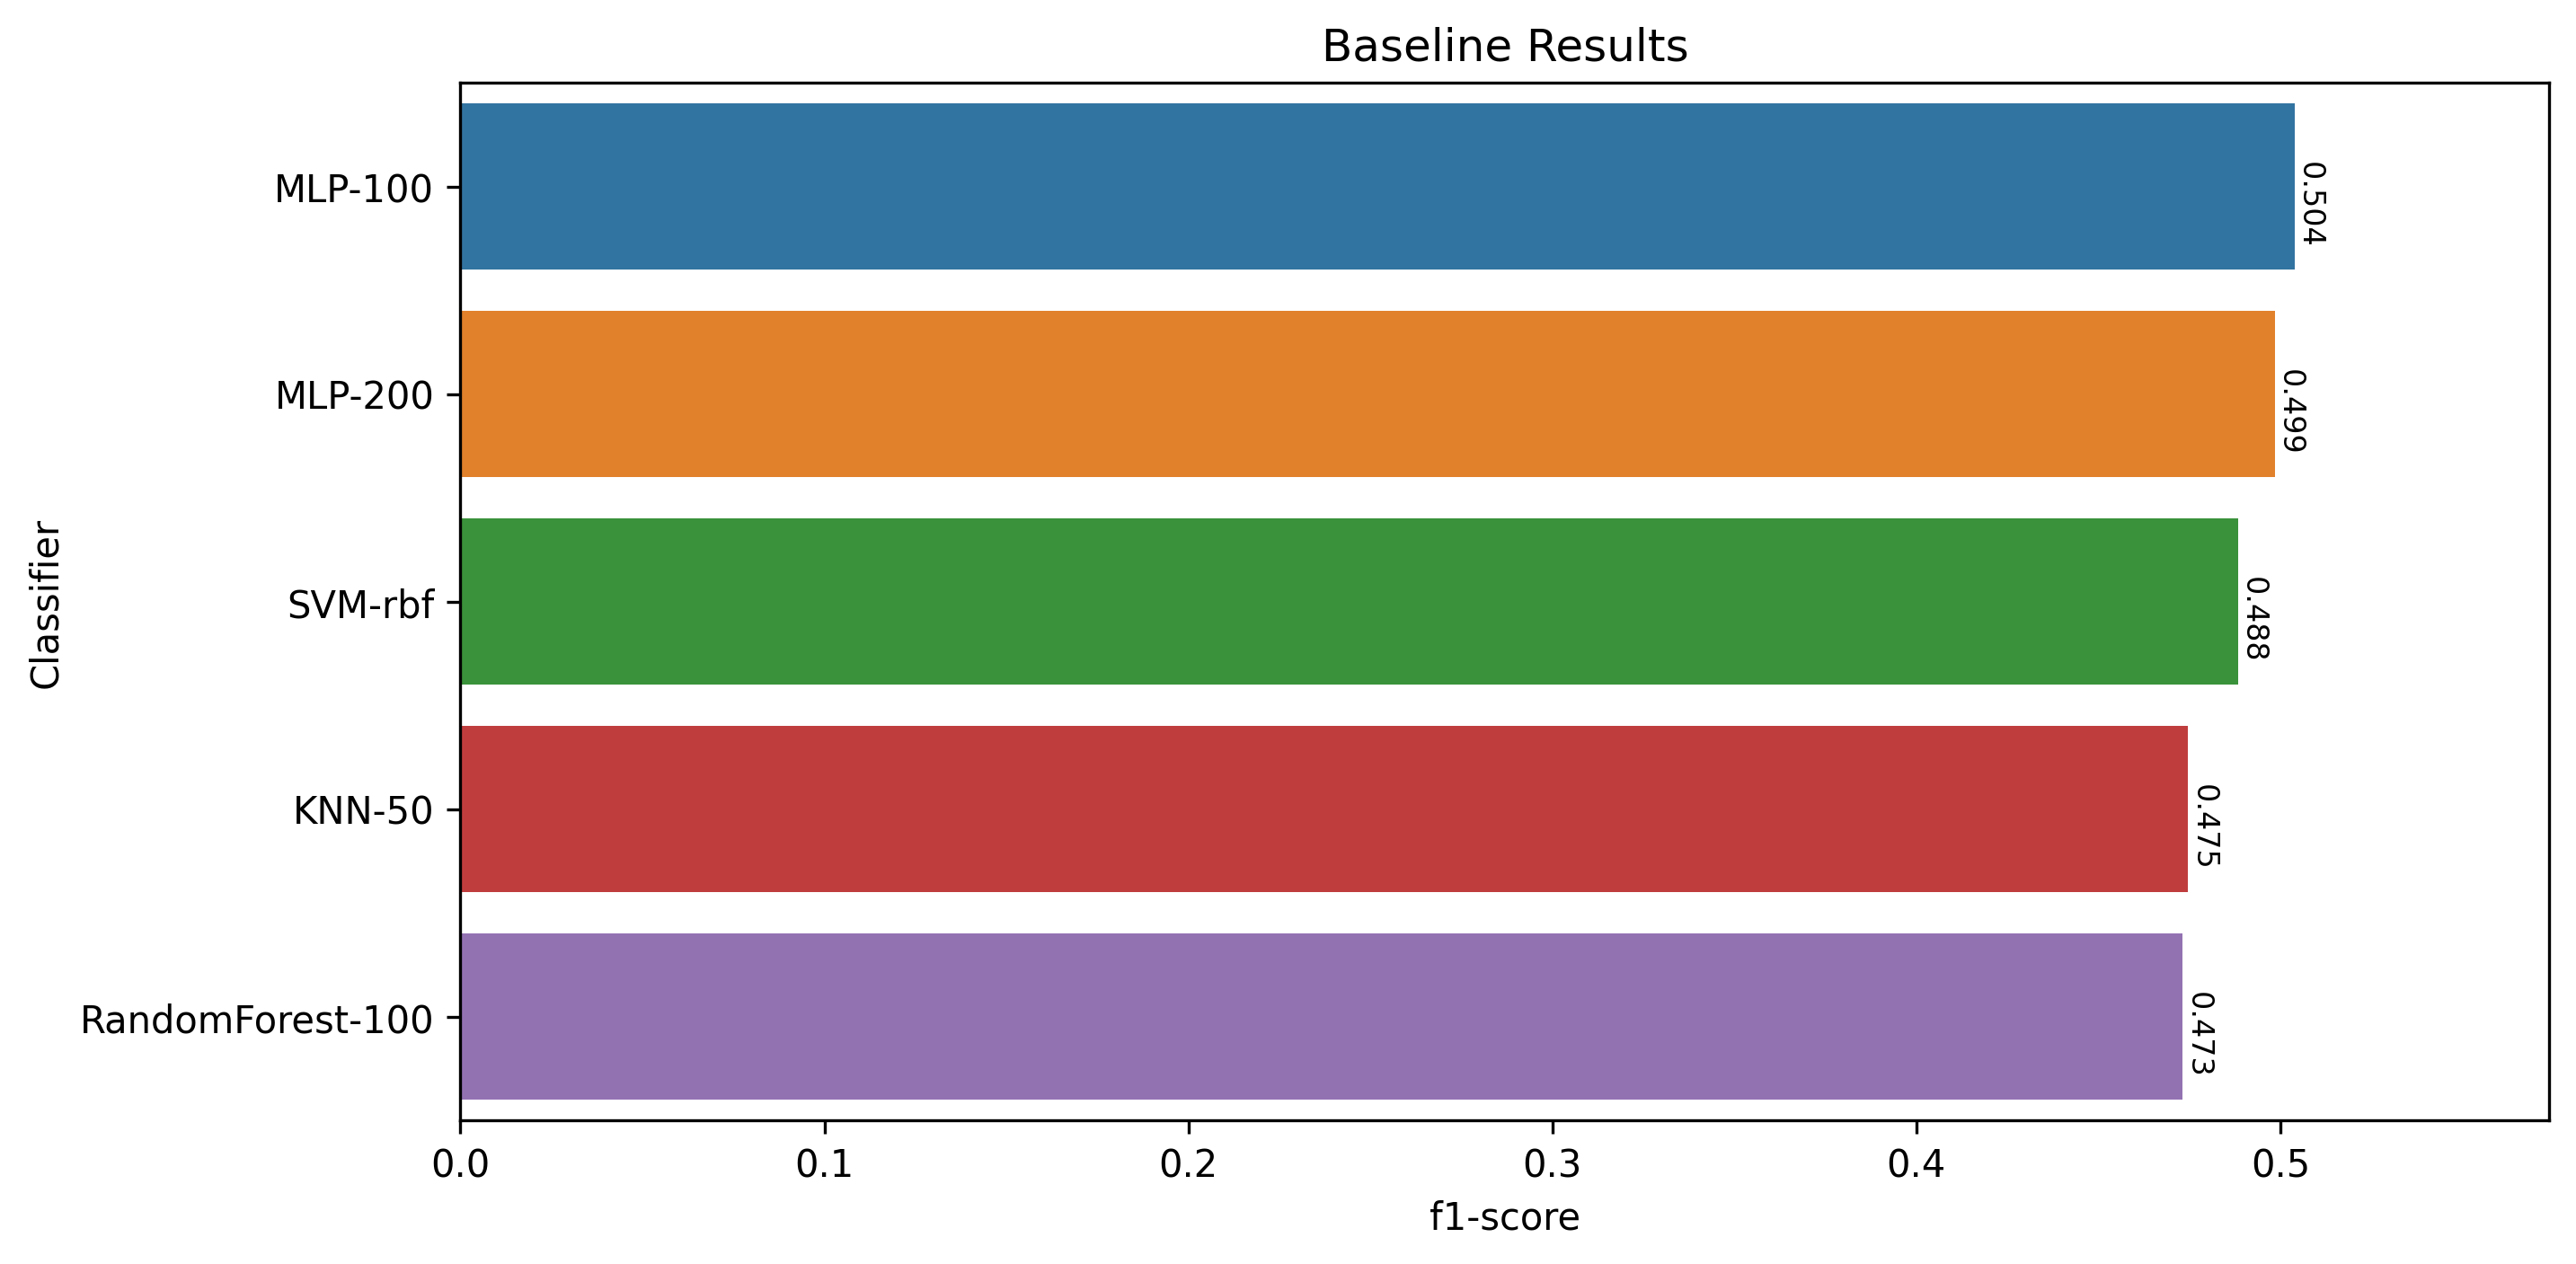

In [55]:

plot_results(baseline_results, 'f1-score')


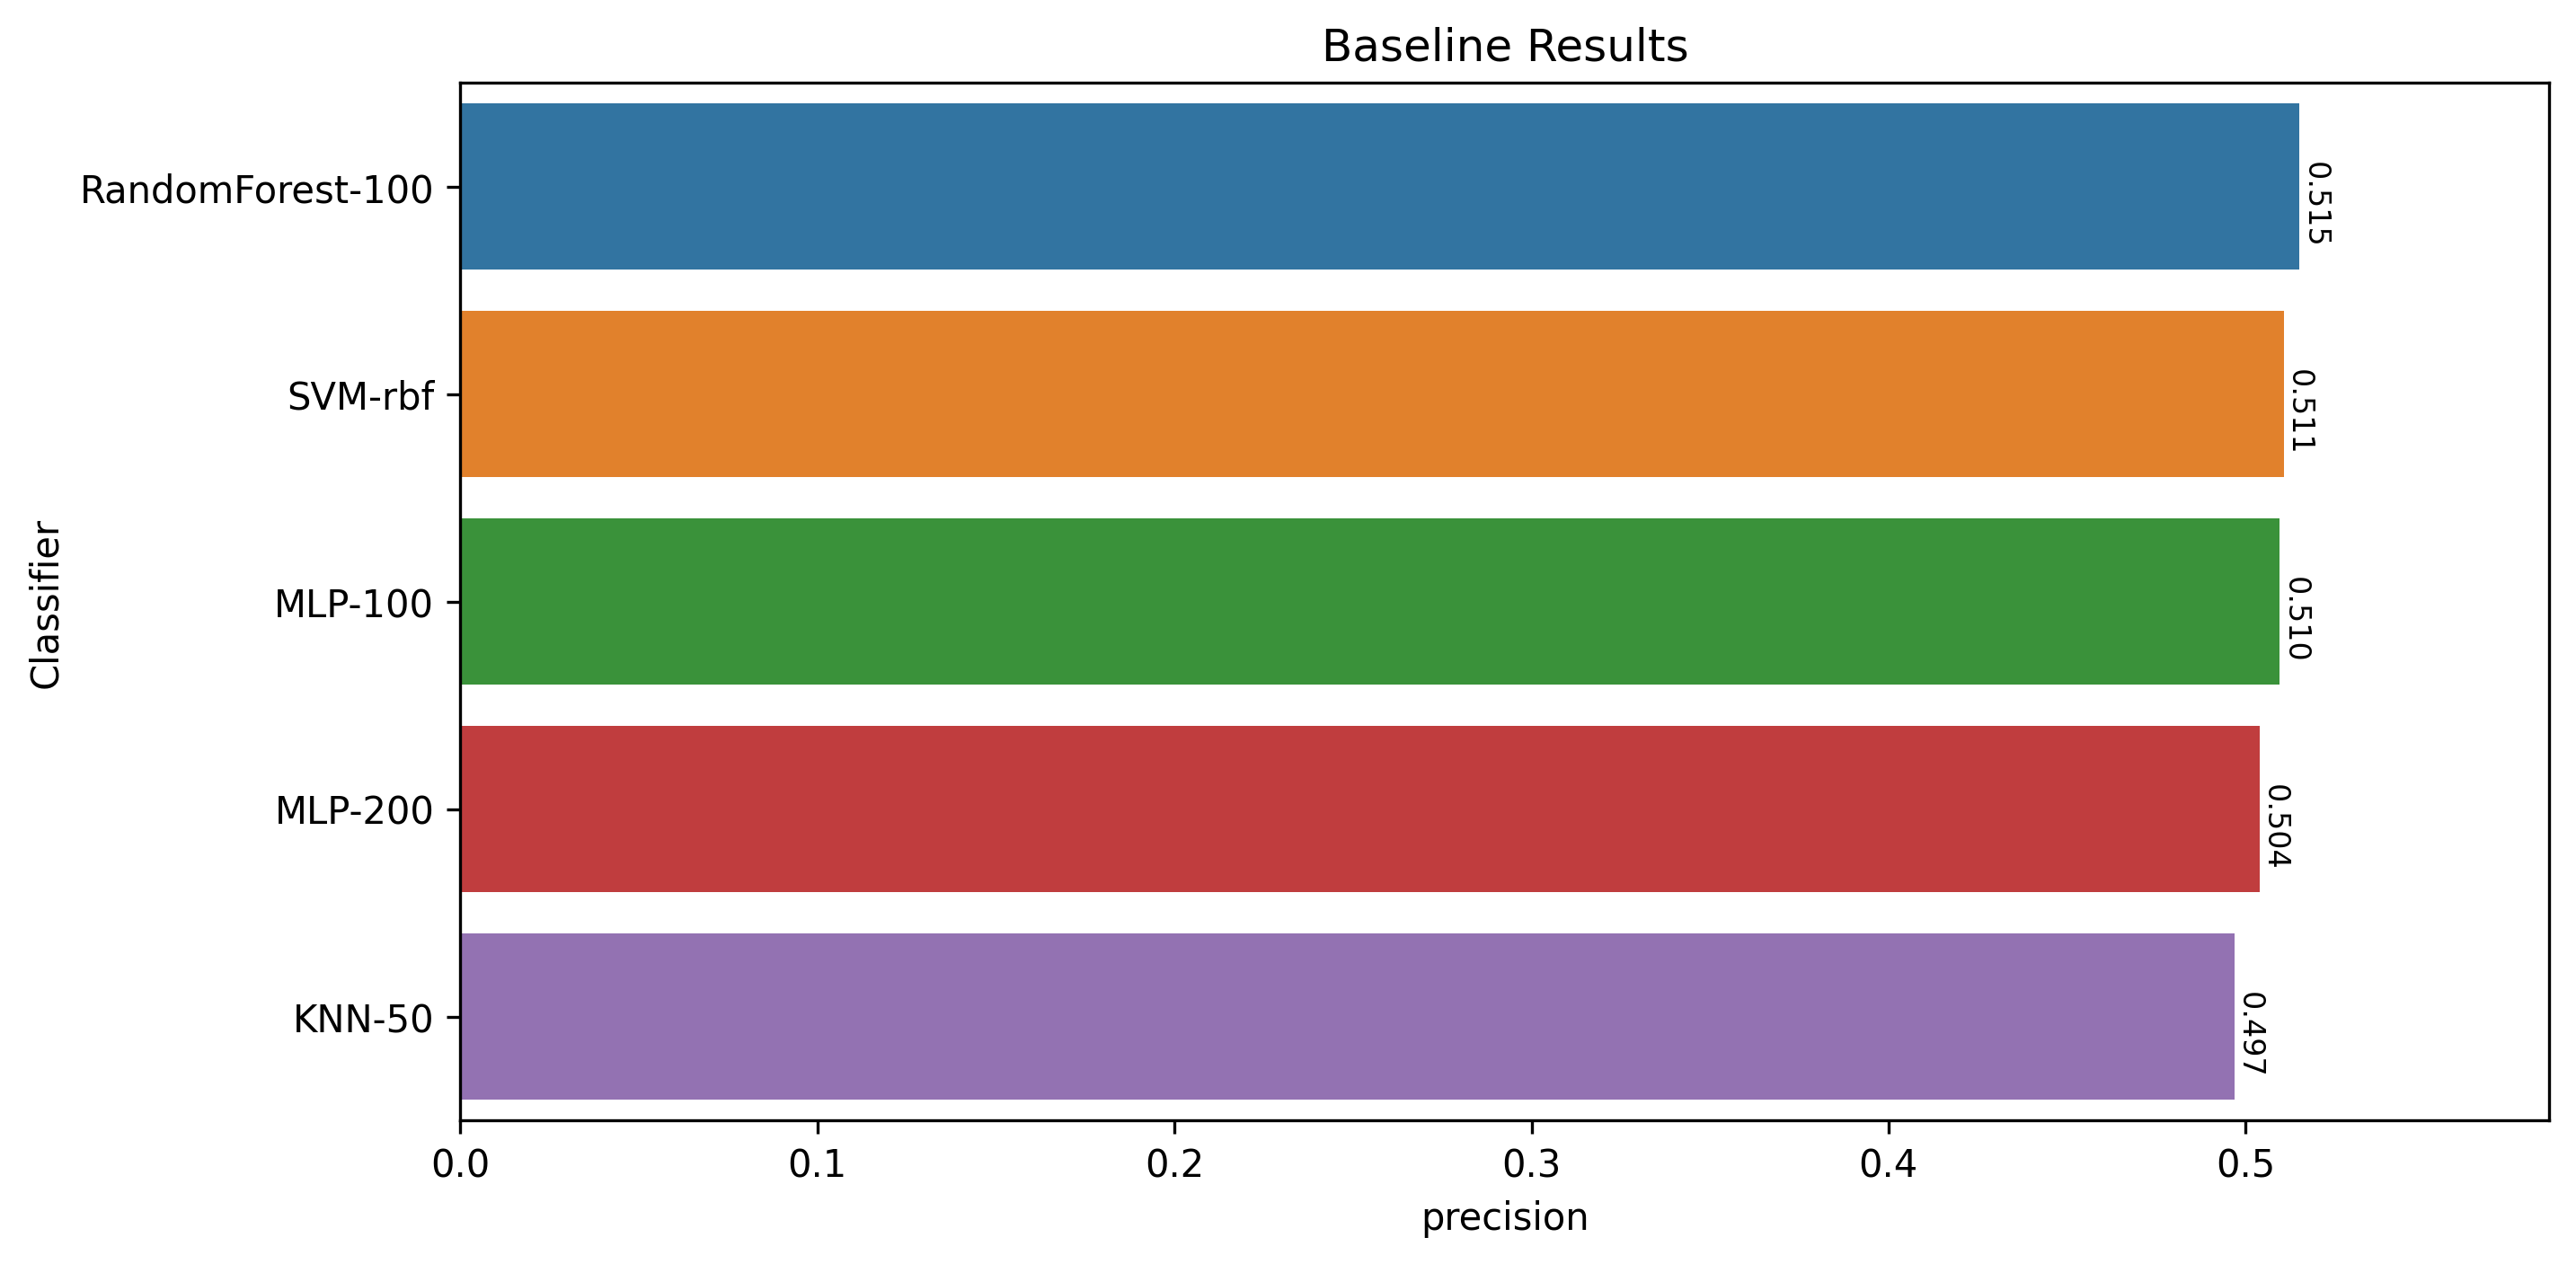

In [56]:
plot_results(baseline_results, 'precision')

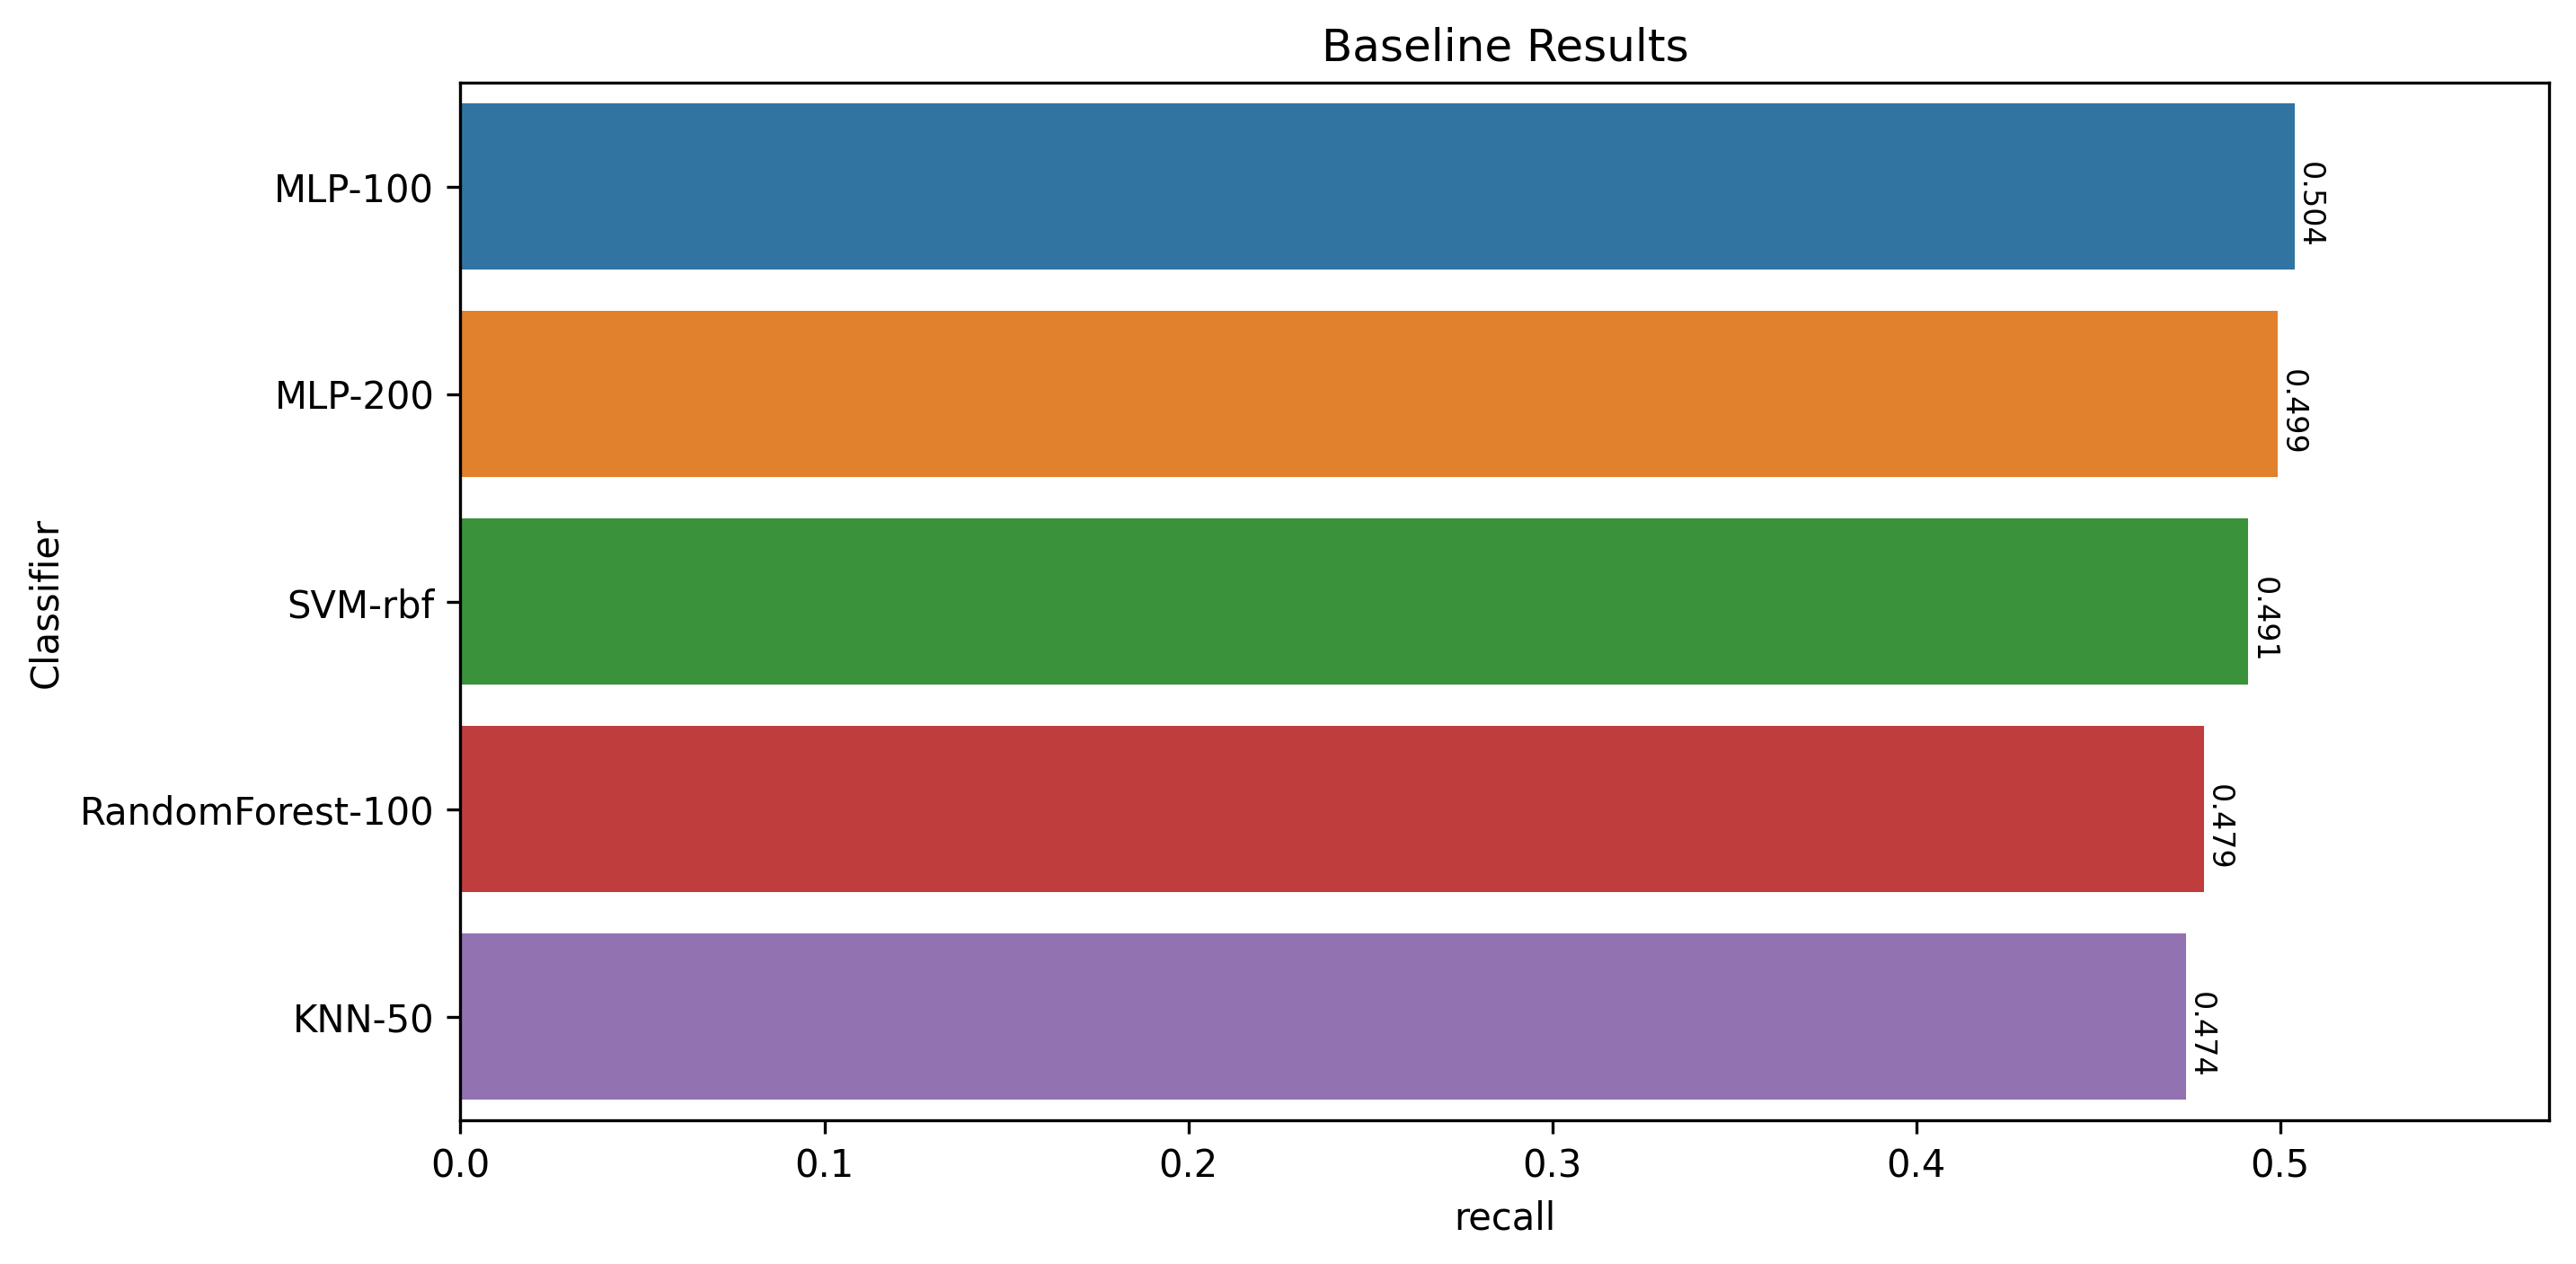

In [57]:
plot_results(baseline_results, 'recall')

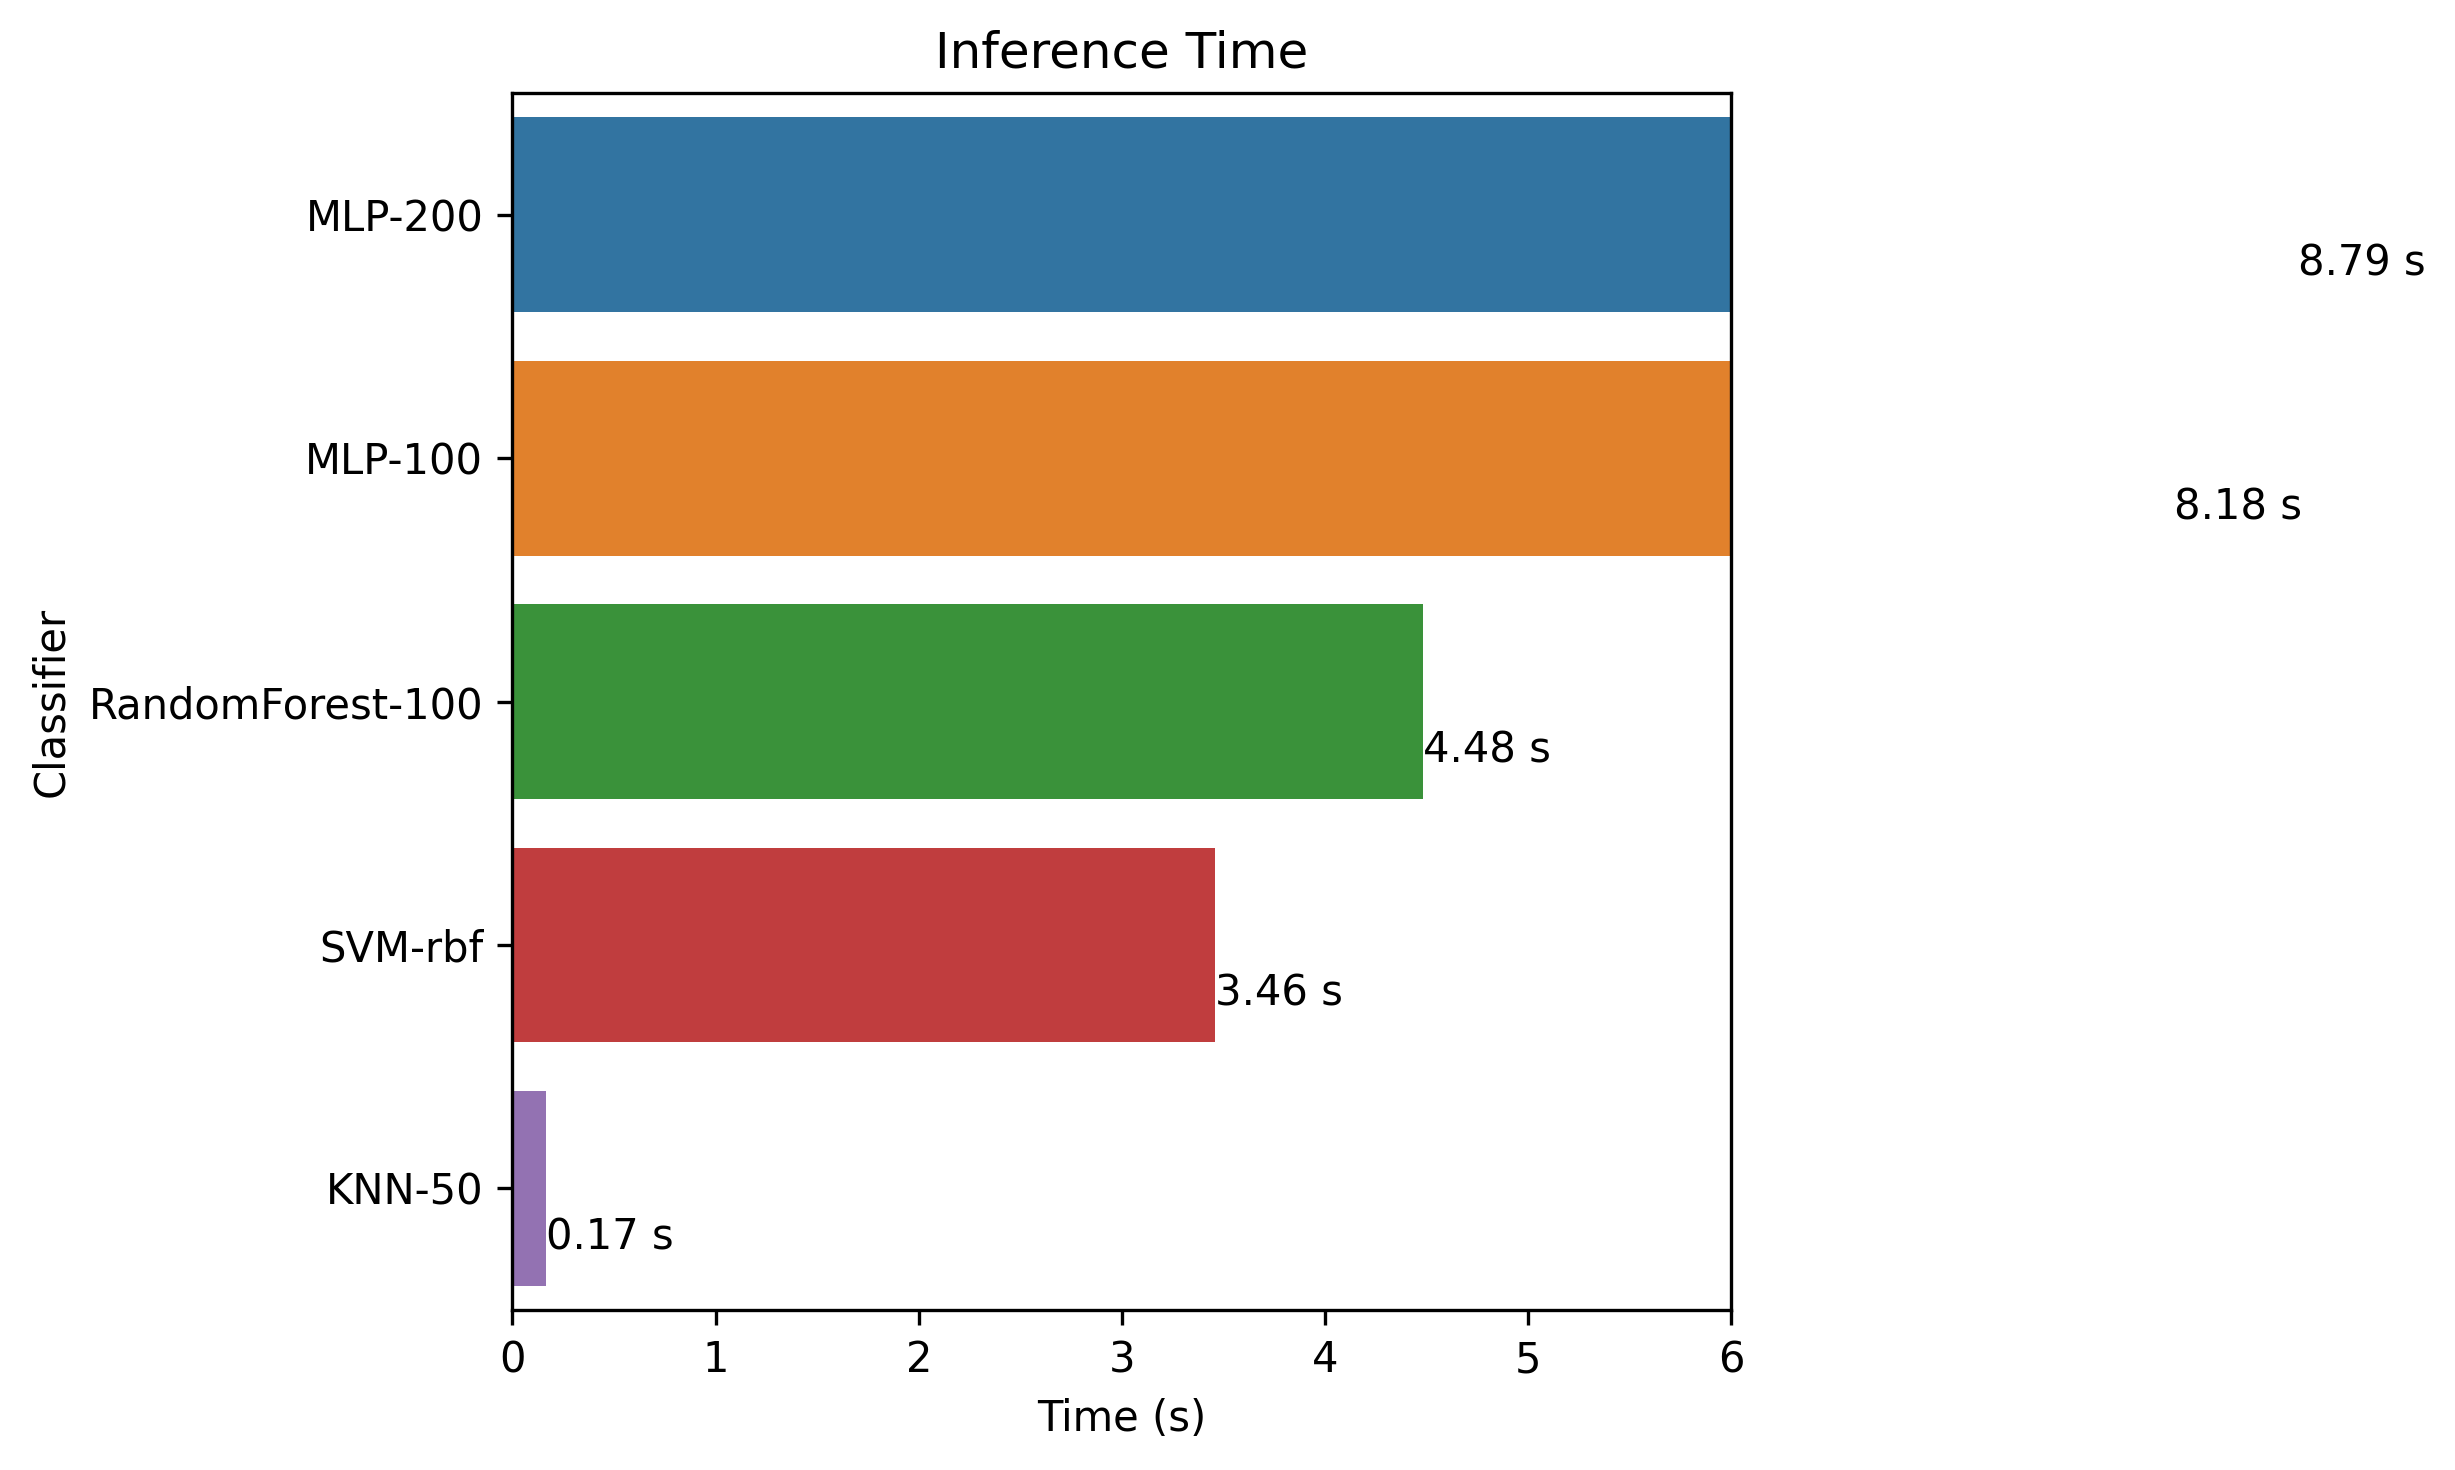

In [58]:
plot_inference_time(baseline_results, 'Inference Time', 'Time (s)')

In [59]:
baseline_results["size"] = X_train_reduced.nbytes

with open("results_FEVER.pickle", "wb") as pickle_file:
    pickle.dump(baseline_results, pickle_file)

***Aspect Sentiment Classification***

Load Data

In [60]:
df = pd.read_json('datasets/Aspect_Sentiment/train.json', orient="index")
df.rename(columns={'polarity': 'label'}, inplace=True)
df = df.sample(n=df.shape[0], random_state=2000, replace=False).reset_index(drop=True)
df_train, df_dev = np.split(df, [int(.9*len(df))])

df_test = pd.read_json('datasets/Aspect_Sentiment/test.json', orient="index")
df_test.rename(columns={'polarity': 'label'}, inplace=True)
df_test = df_test.sample(n=df_test.shape[0], random_state=2000, replace=False).reset_index(drop=True)

Generate SBERT embeddings

In [62]:
# X_train = model.encode(list(df_train.sentence))
# X_dev = model.encode(list(df_dev.sentence))
# X_test = model.encode(list(df_test.sentence))

# y_train = df_train["label"]
# y_dev = df_dev["label"]

In [63]:
# # save the embedding results
# pickle.dump(X_train, open("datasets/Aspect_Sentiment/embeddings/train_embeddings_originals.p","wb" ))
# pickle.dump(X_dev, open("datasets/Aspect_Sentiment/embeddings/dev_embeddings_originals.p", "wb"))
# pickle.dump(X_test, open("datasets/Aspect_Sentiment/embeddings/test_embeddings_originals.p", "wb"))

# # save the labels
# pickle.dump(y_train, open("datasets/Aspect_Sentiment/embeddings/train_labels_originals.p", "wb"))
# pickle.dump(y_dev, open("datasets/Aspect_Sentiment/embeddings/dev_labels_originals.p", "wb"))

In [64]:
# load the embeddings
X_train = pickle.load(open("datasets/Aspect_Sentiment/embeddings/train_embeddings_originals.p", "rb"))
X_dev = pickle.load(open("datasets/Aspect_Sentiment/embeddings/dev_embeddings_originals.p", "rb"))
X_test = pickle.load(open("datasets/Aspect_Sentiment/embeddings/test_embeddings_originals.p", "rb"))

# load the labels
y_train = pickle.load(open("datasets/Aspect_Sentiment/embeddings/train_labels_originals.p", "rb"))
y_dev = pickle.load(open("datasets/Aspect_Sentiment/embeddings/dev_labels_originals.p", "rb"))

Calculate TF-IDF Score

In [65]:
#Tokenize each senetence
df_train["list_of_words"] = 0

for i in range(len(df_train['sentence'])):
    sentence = df["sentence"][i].lower()
    sentence = re.sub(r'[^\w\s]', '', sentence)
 
    result = sentence.split()
    df_train["list_of_words"][i] = result
    

C:\Users\HP\AppData\Local\Temp\ipykernel_7560\3761323428.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["list_of_words"][i] = result


In [66]:
tf_matrix = create_tf_matrix(df_train["list_of_words"])
idf_matrix = create_idf_matrix(df_train["list_of_words"])

tf_idf_matrix = create_tf_idf_matrix(tf_matrix, idf_matrix)

In [67]:
df_train = calculate_sentence_scores(tf_idf_matrix, df_train)

C:\Users\HP\AppData\Local\Temp\ipykernel_7560\1346757543.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["tf_idf_score"][sentence] = sum_of_tf_idf/len_of_sentence


Cluster Embeddings on Similarity and Dimensionality Reduction

In [68]:
embeddings, y_train_reduced = dimensionality_reduction_with_clustering(X_train, y_train, tf_idf_matrix)

X_train_reduced = np.array(embeddings)
y_train_reduced = np.array(y_train_reduced)

Classification

In [69]:
baseline_results = {}

SVM

In [70]:
svm_classification(baseline_results, X_train_reduced, y_train_reduced, X_dev, y_dev)

SVM with kernel: rbf	0.7327188940092166


MLP

In [71]:
mlp_classification(baseline_results, X_train_reduced, y_train_reduced, X_dev, y_dev)

MLP with layers: 200	0.7188940092165899
MLP with layers: 100	0.7235023041474654


Random Forest

In [72]:
random_forest_classification(baseline_results, X_train_reduced, y_train_reduced, X_dev, y_dev)

Random Forest with n_estimators: 100	0.728110599078341


KNN

In [73]:
knn_classification(baseline_results, X_train_reduced, y_train_reduced, X_dev, y_dev)

KNN with n_neighbors: 50	0.6728110599078341


Plot Results

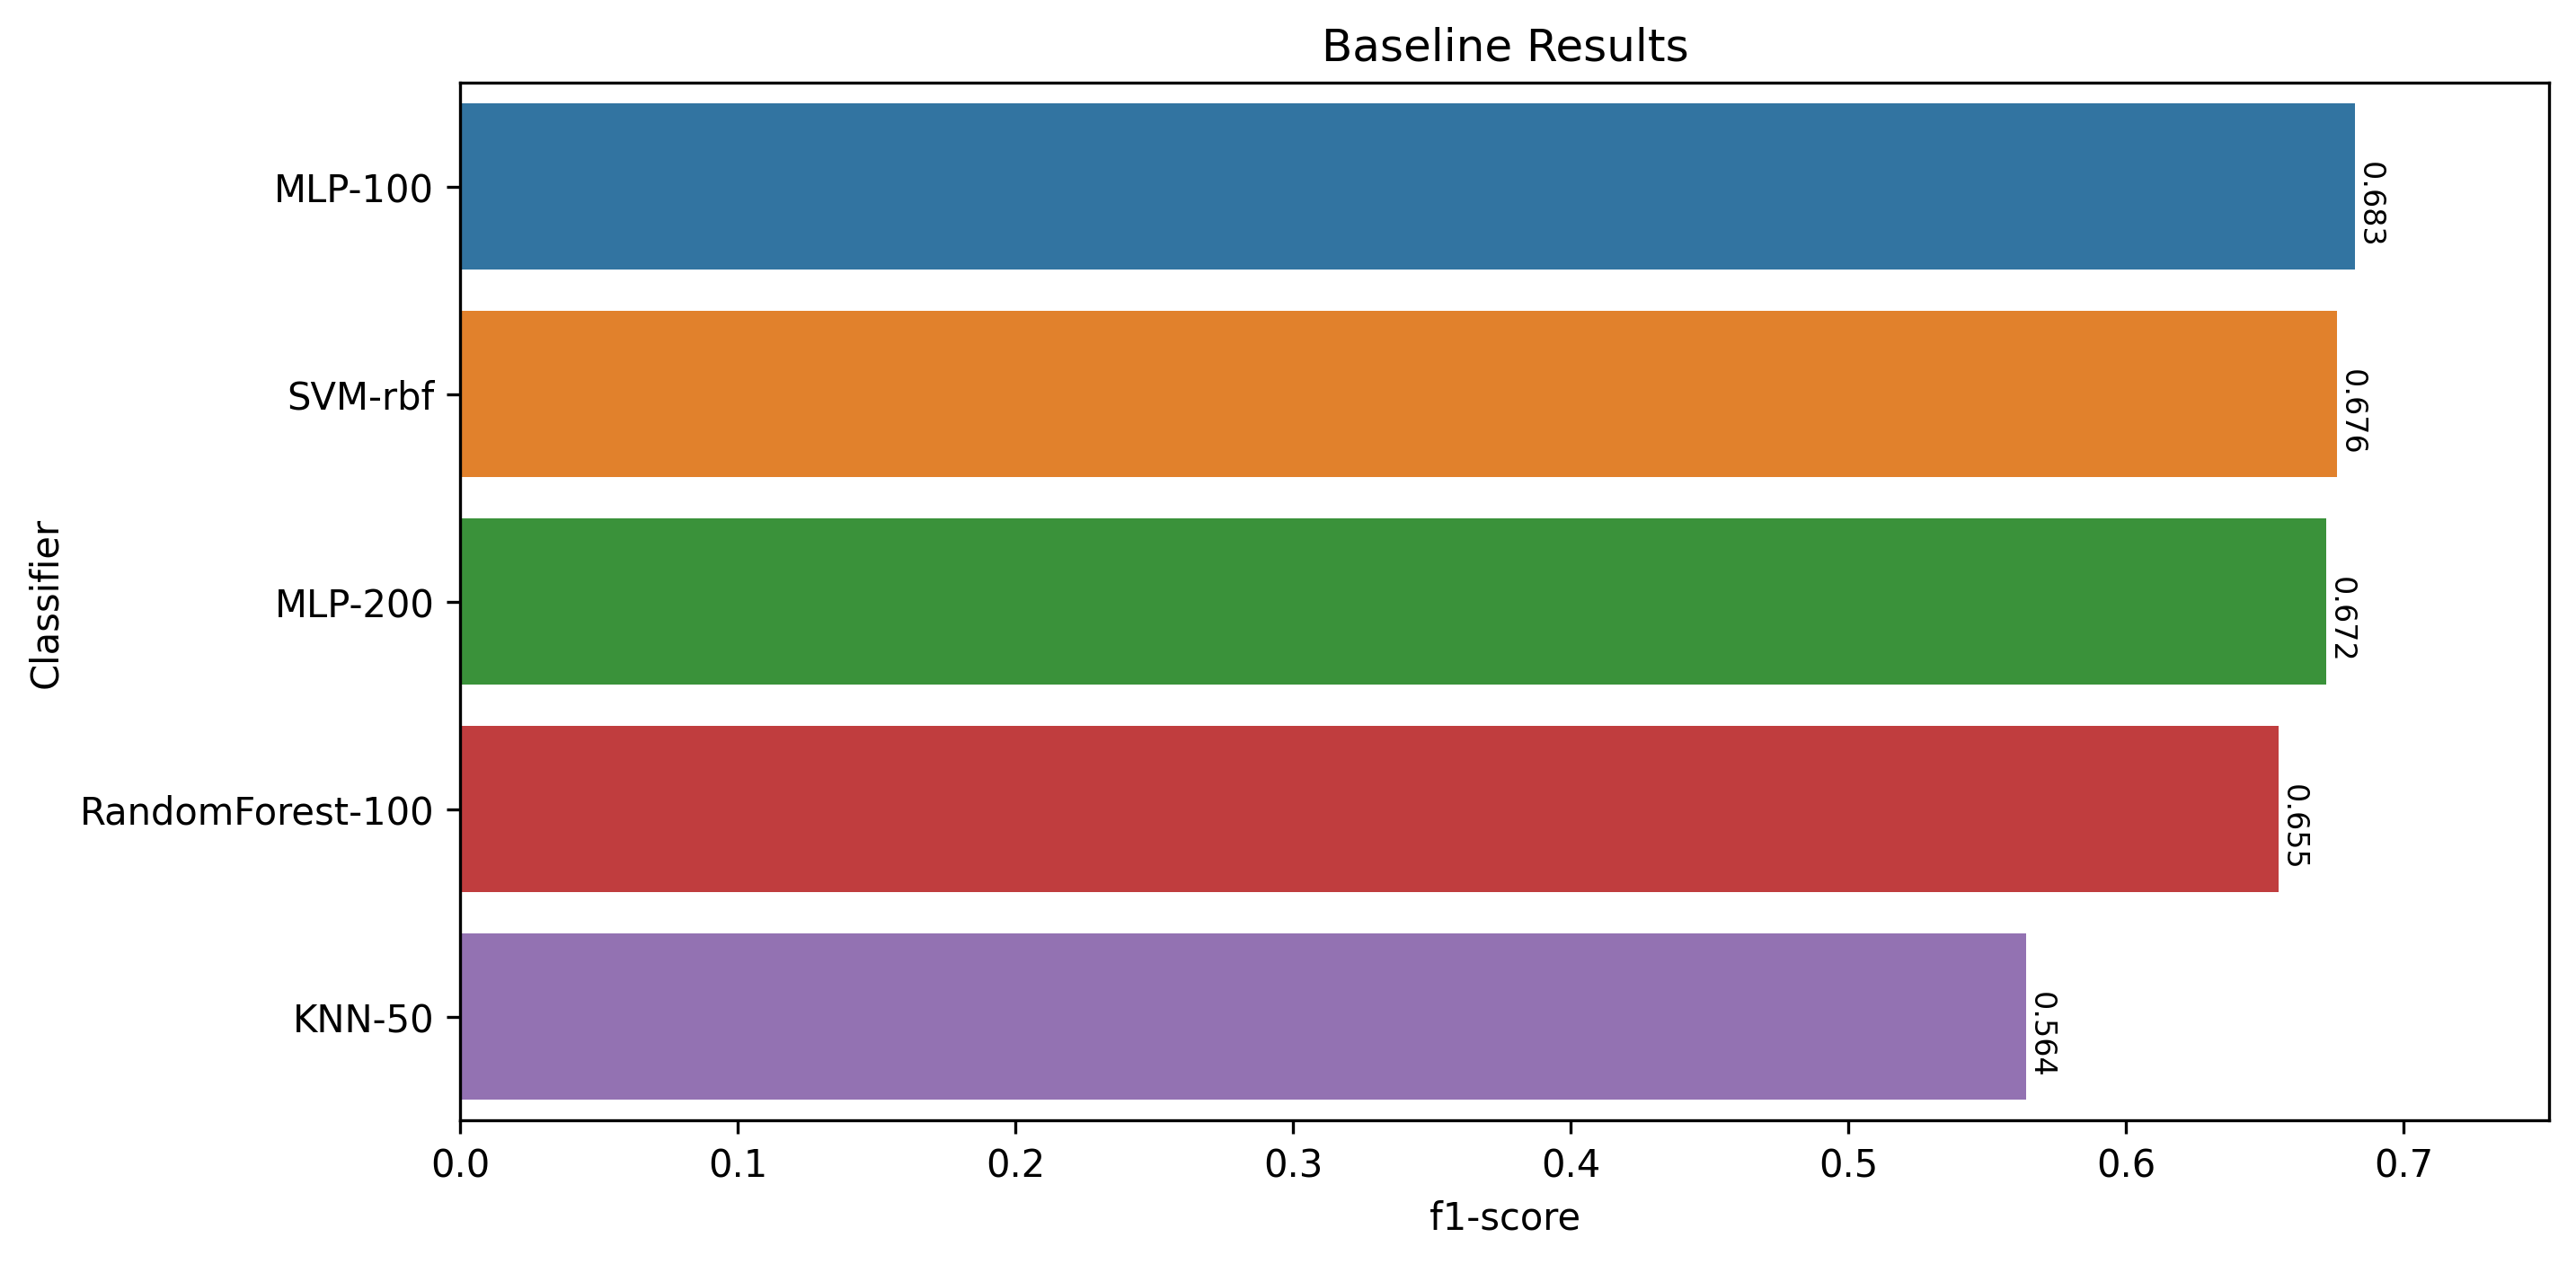

In [74]:
plot_results(baseline_results, 'f1-score')

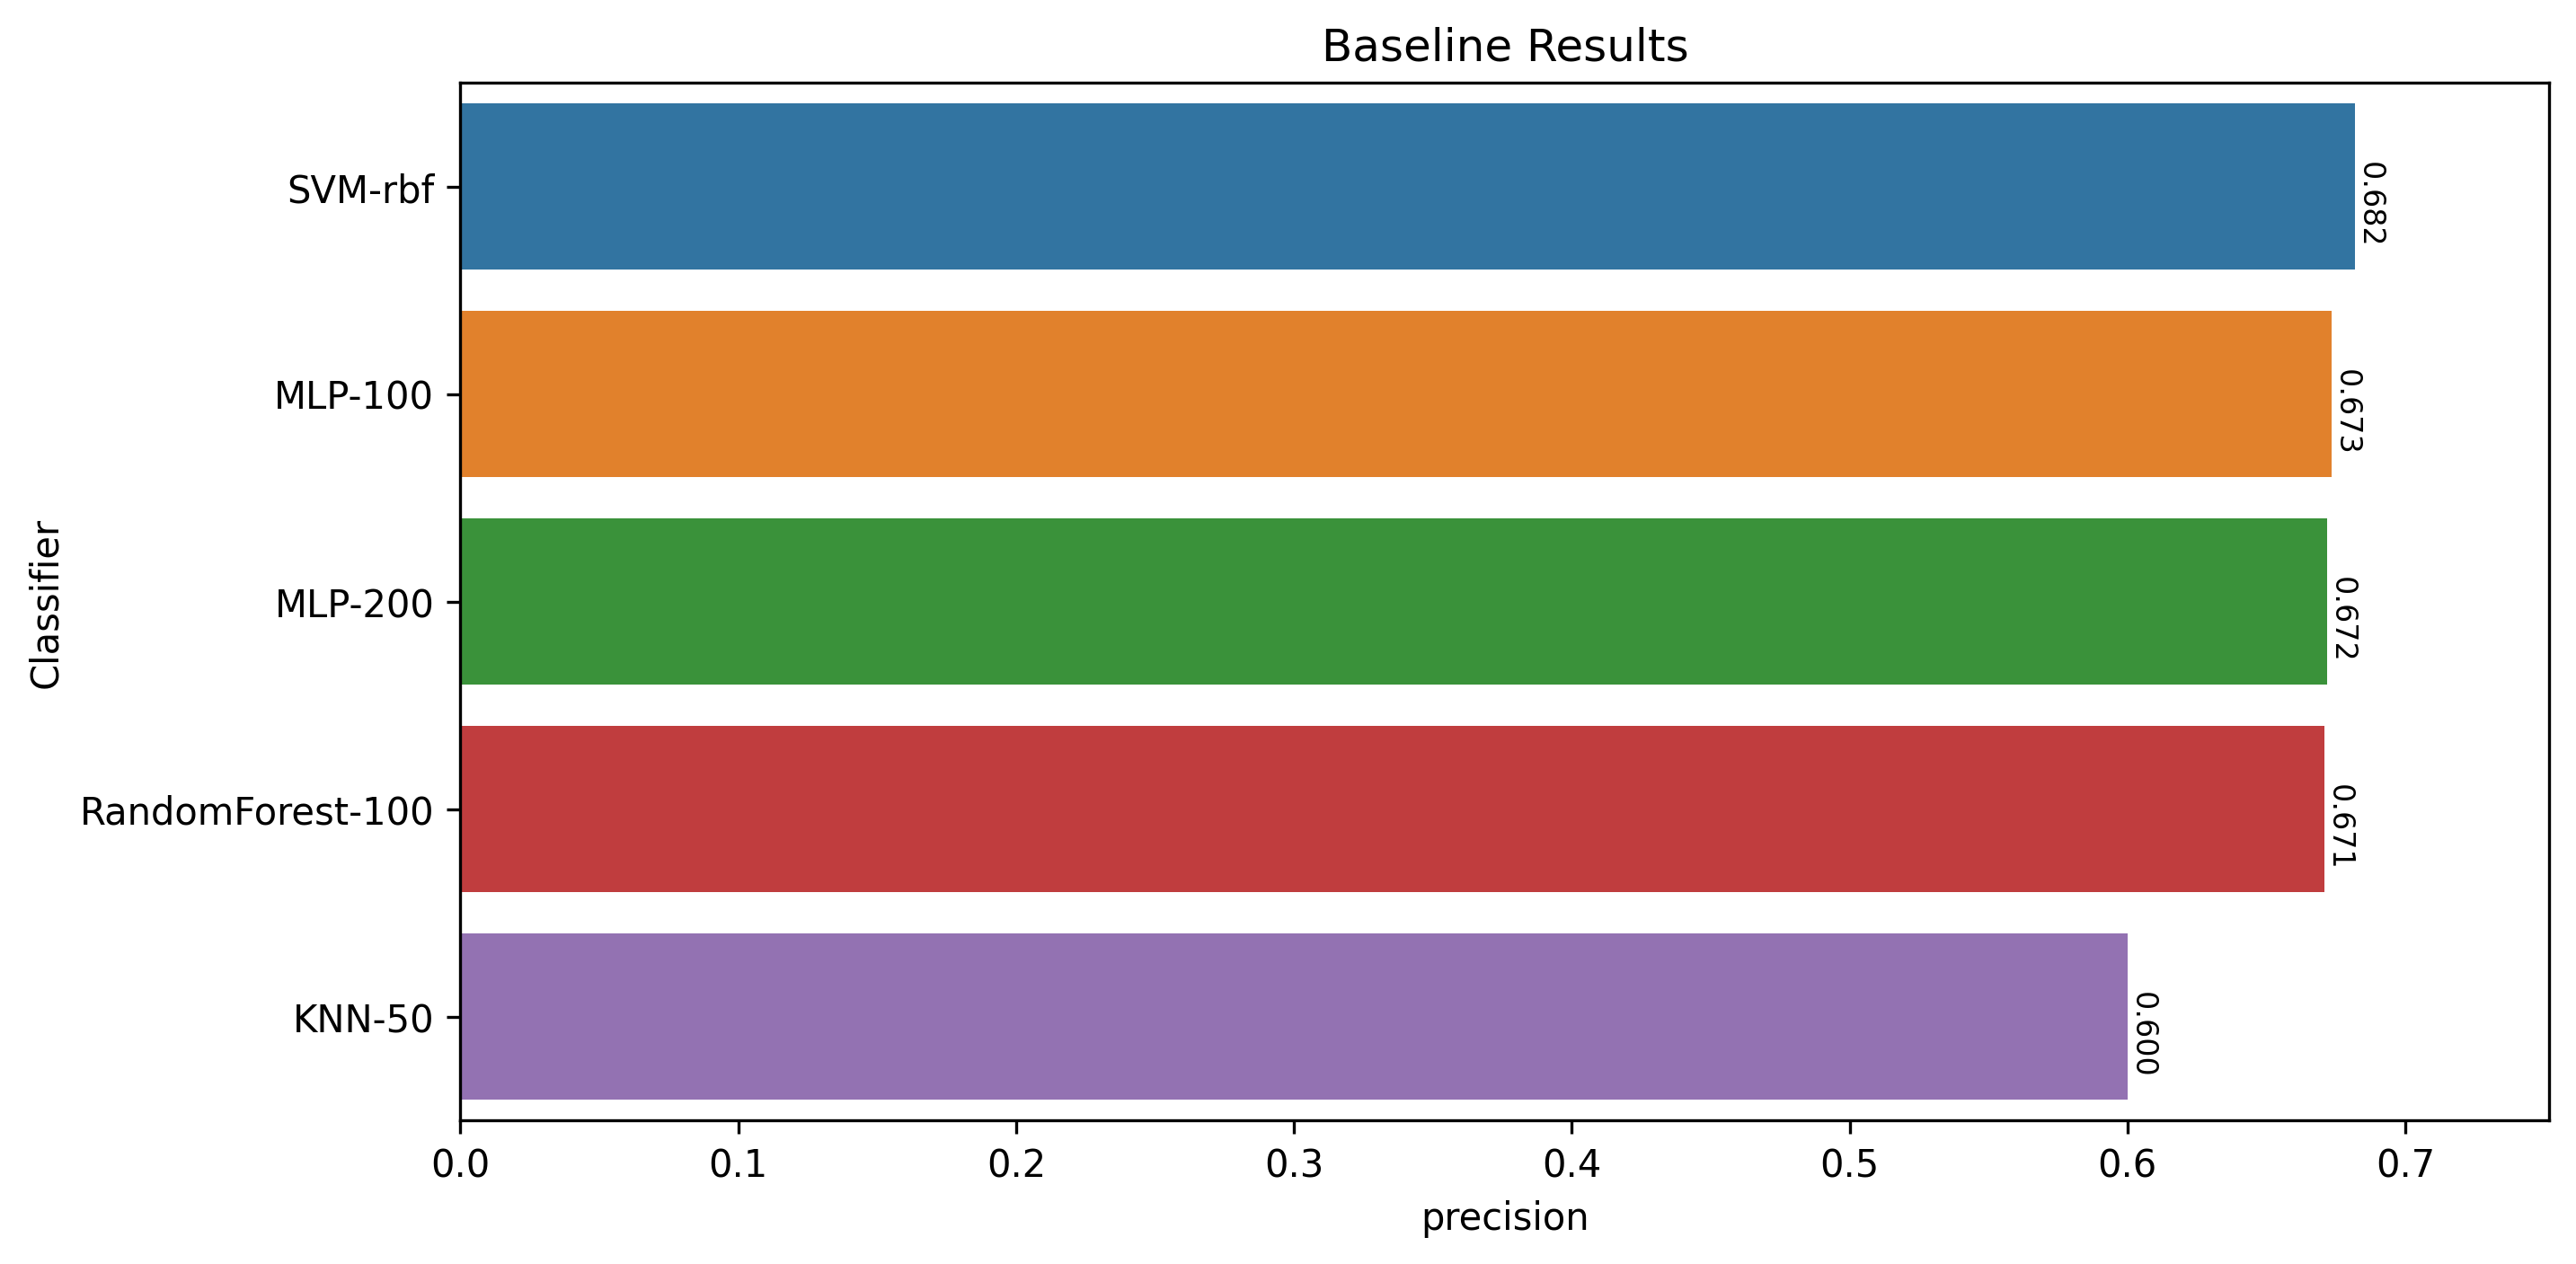

In [188]:
plot_results(baseline_results, 'precision')

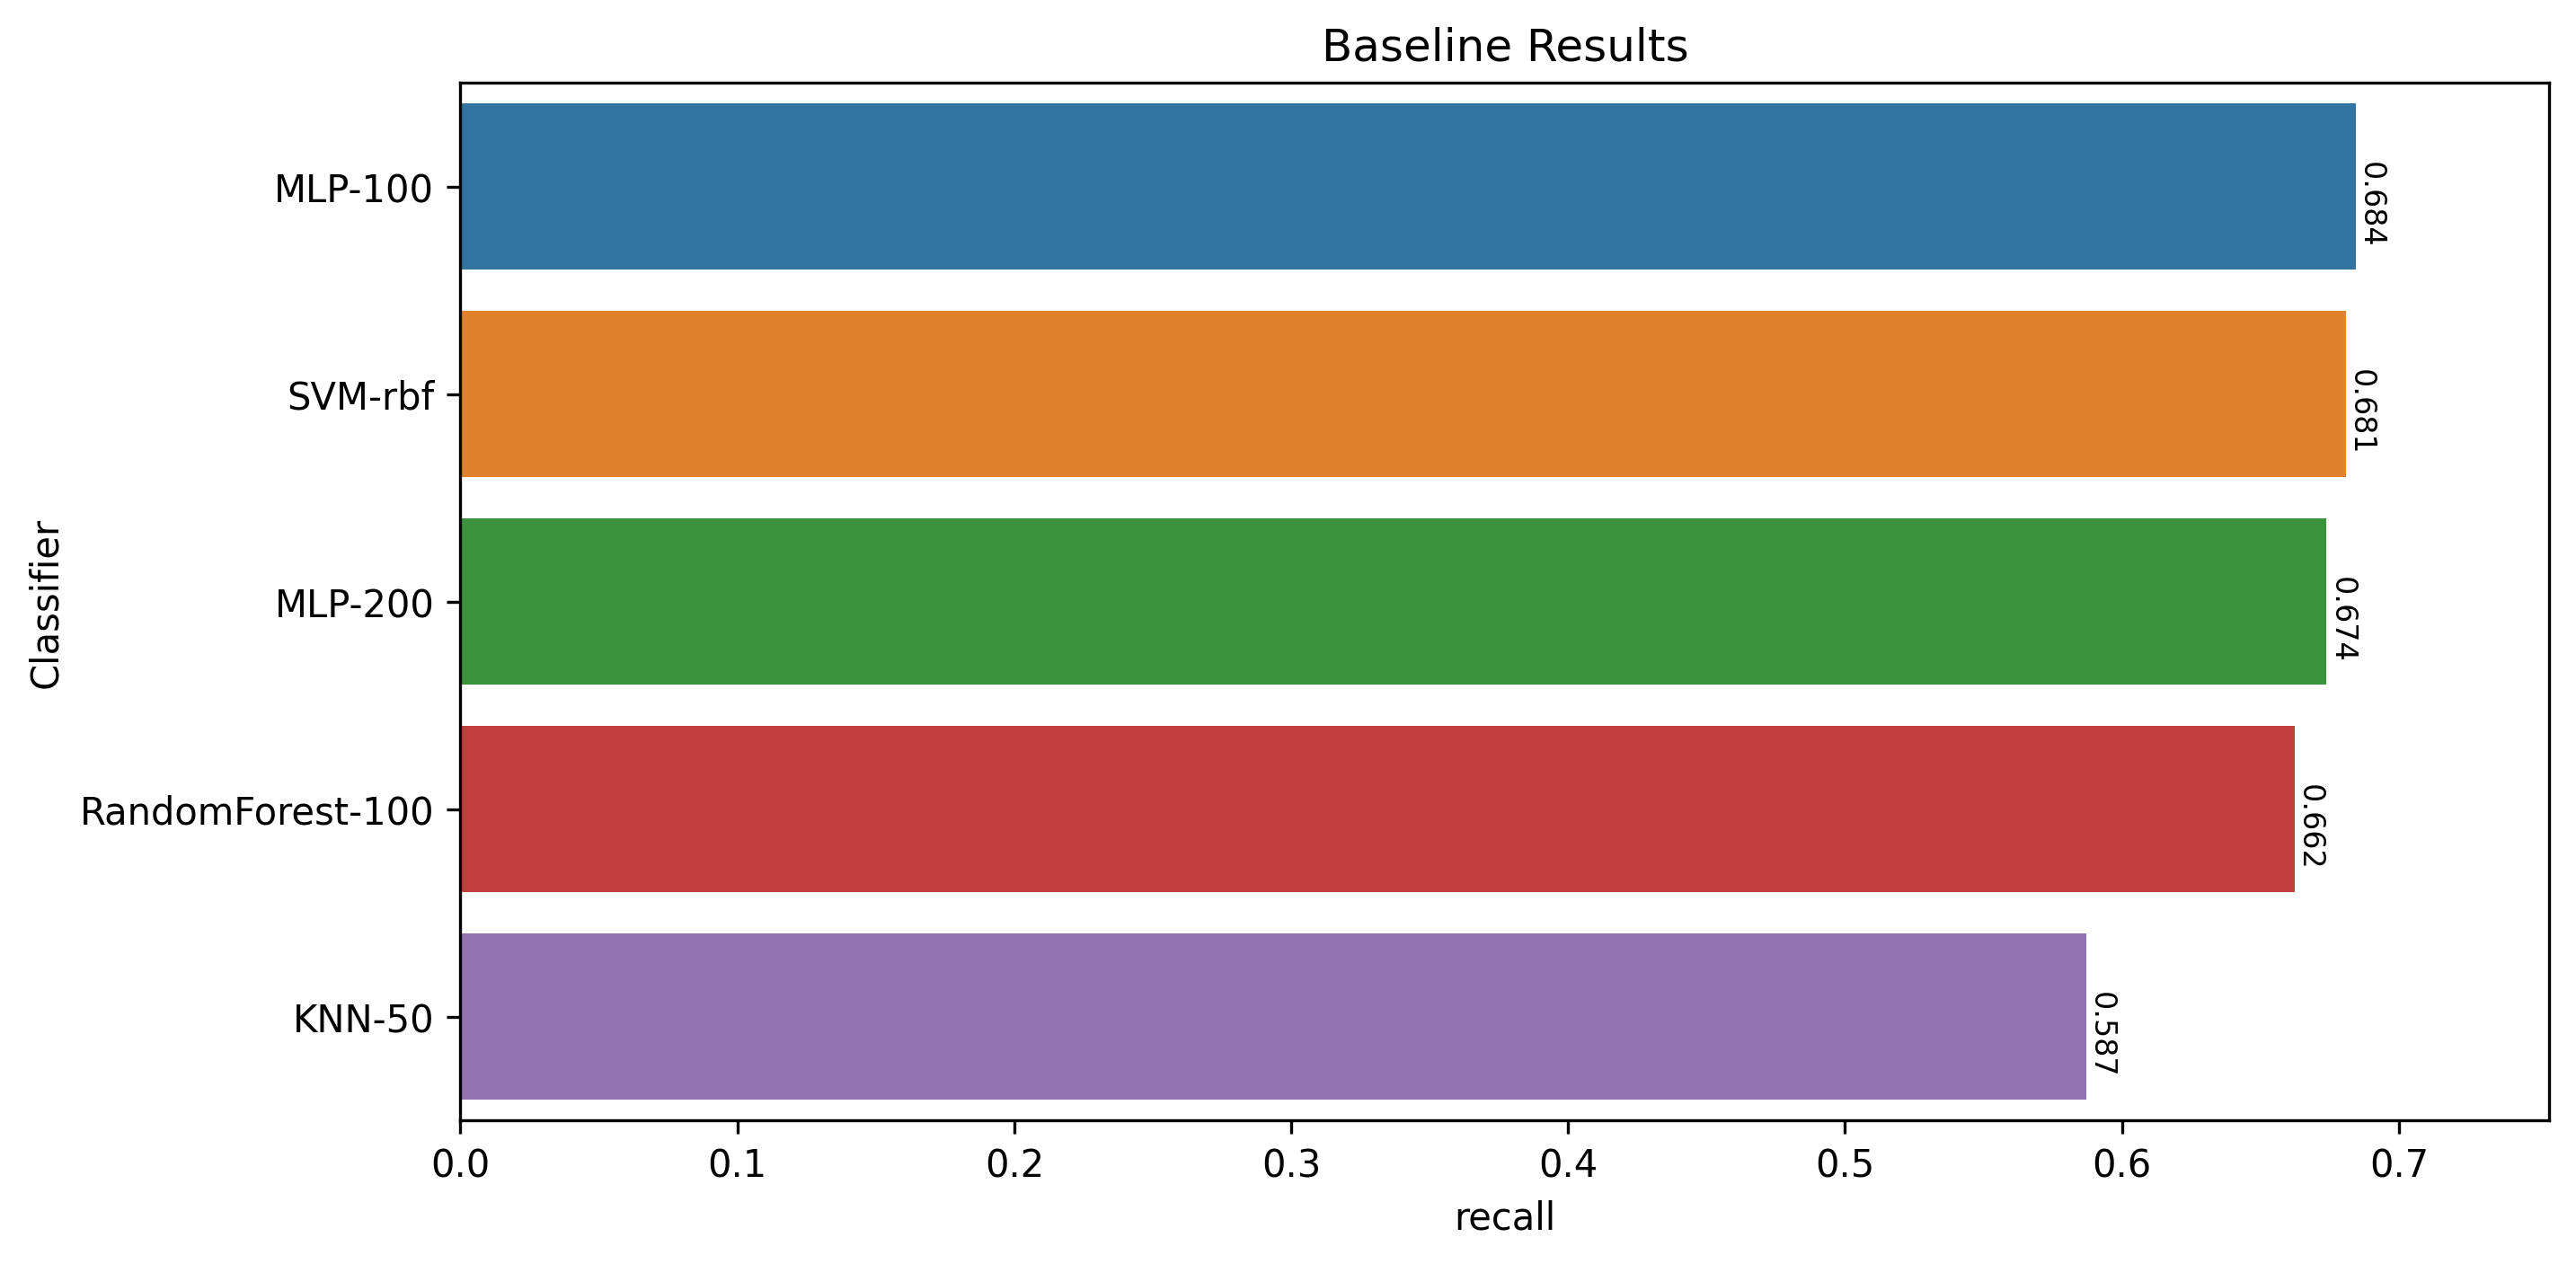

In [75]:
plot_results(baseline_results, 'recall')

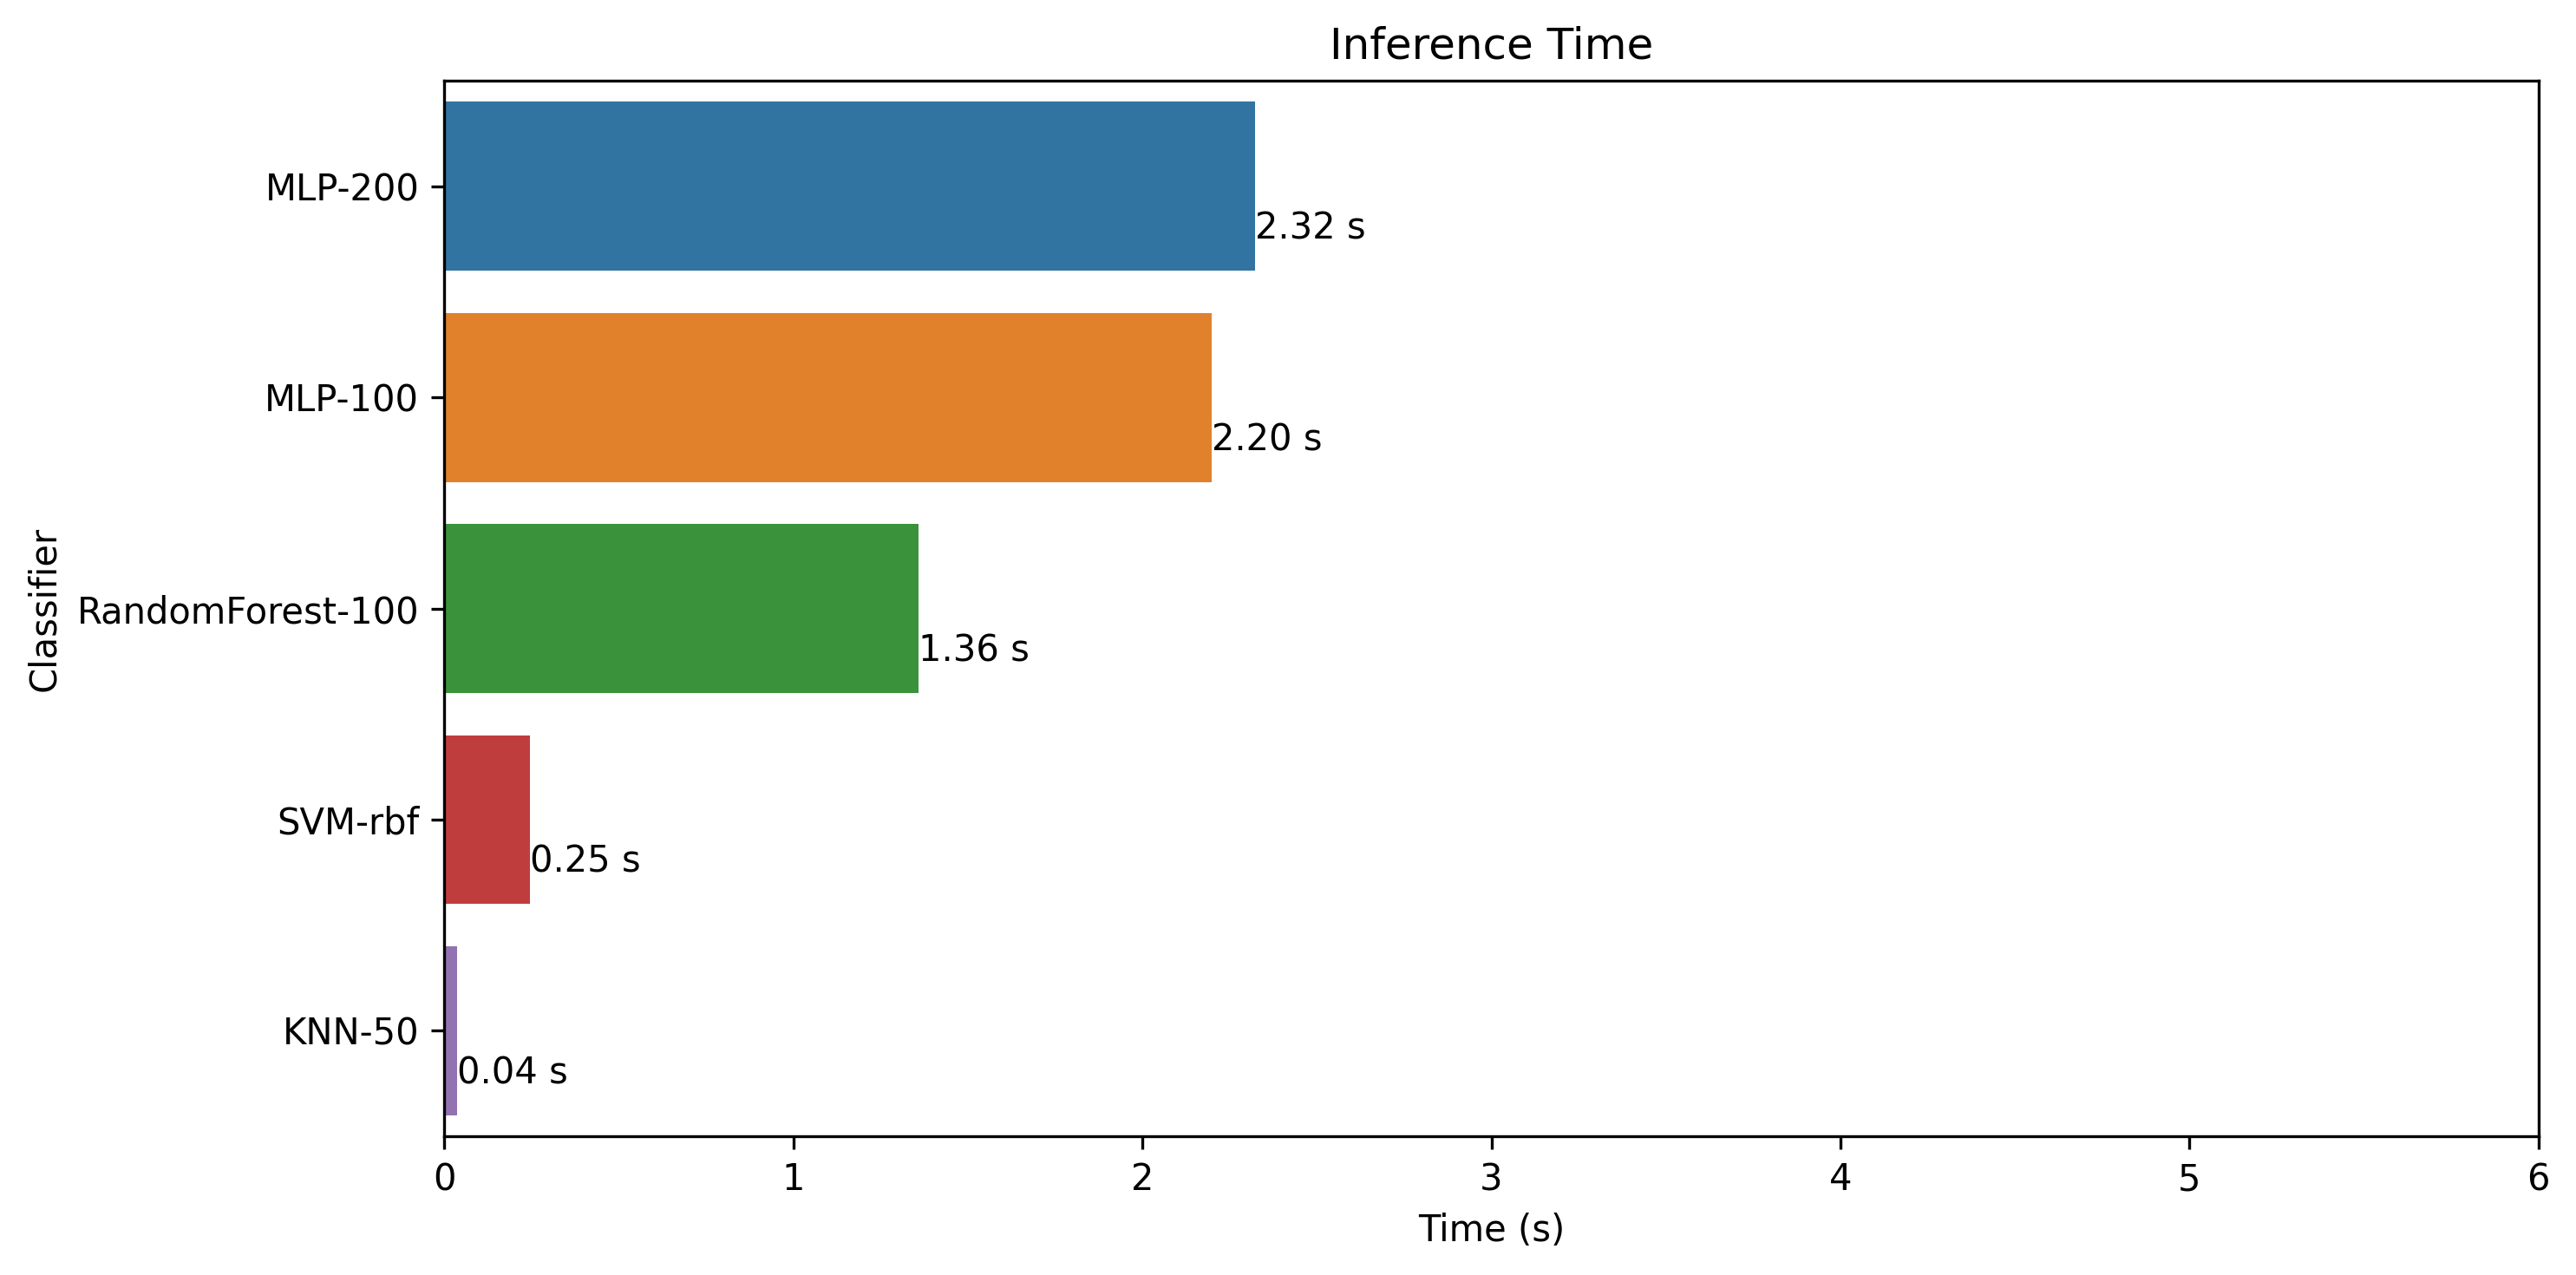

In [190]:
plot_inference_time(baseline_results, 'Inference Time', 'Time (s)')

In [76]:
baseline_results["size"] = X_train_reduced.nbytes

with open("results_aspectSentimentAnalysis.pickle", "wb") as pickle_file:
    pickle.dump(baseline_results, pickle_file)